# Bank Customer Churn -  Ensemble Learning 


In [1]:
#![churn_bank.jpg](attachment:churn_bank.jpg)

# Importando Bibliotecas 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import logging
import optuna
import xgboost as xgb
import torch
import torch.nn as nn
import shap
import lime.lime_tabular
import scipy.sparse
from sklearn.inspection import PartialDependenceDisplay
from xgboost import plot_importance
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score,
    roc_curve, confusion_matrix, auc
)

from optuna.samplers import TPESampler
import pickle
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import joblib

from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.callbacks import EarlyStopping
import math
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




########################### para KAGGLE ################################################################################################################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
########################################################################################################################################################


c:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


# Análise Exploratória (EDA) & Data Wrangling 


In [3]:

# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Analisando primeiras impressões da base de dados


In [4]:
#Dimensões 
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])


Numero de linhas: 10000
Numero de colunas: 18


In [5]:
#tipos
base_original.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [6]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [7]:
#contando a quantidade de zeros em cada coluna para verificar se elas tem 
# informacao suficiente para entrar no modelo futuramente

for col in base_original.columns:
    zero_count = (base_original[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")

#nao foi constatao nada muito impactante, as variaveis com mais zero sao categoriacas (binarias) 
# Balance seria a unica a se preocupar, mas vamos manter. 






 'RowNumber': 0 valores zero

 'CustomerId': 0 valores zero

 'Surname': 0 valores zero

 'CreditScore': 0 valores zero

 'Geography': 0 valores zero

 'Gender': 0 valores zero

 'Age': 0 valores zero

 'Tenure': 413 valores zero

 'Balance': 3617 valores zero

 'NumOfProducts': 0 valores zero

 'HasCrCard': 2945 valores zero

 'IsActiveMember': 4849 valores zero

 'EstimatedSalary': 0 valores zero

 'Exited': 7962 valores zero

 'Complain': 7956 valores zero

 'Satisfaction Score': 0 valores zero

 'Card Type': 0 valores zero

 'Point Earned': 0 valores zero


In [8]:
#removidas por serem meramente identificadoras: RowNumber, CustomerId e Surname

#removida Gender por poder inviesar o modelo de alguma formna descriminativa, é uma boa pratica de LGPD nao usar dados sensiveis como esse etc. 
 

df = base_original[['CreditScore',
                    #'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

,EstimatedSalary,Balance,CreditScore,Age,Tenure,Point Earned
count,"10.000,0","10.000,0","10.000,0","10.000,0","10.000,0","10.000,0"
mean,"100.090,2","76.485,9","650,5","38,9","5,0","606,5"
std,"57.510,5","62.397,4","96,7","10,5","2,9","225,9"
min,"11,6","0,0","350,0","18,0","0,0","119,0"
25%,"51.002,1","0,0","584,0","32,0","3,0","410,0"
50%,"100.193,9","97.198,5","652,0","37,0","5,0","605,0"
75%,"149.388,2","127.644,2","718,0","44,0","7,0","801,0"
max,"199.992,5","250.898,1","850,0","92,0","10,0","1.000,0"


* Resumo estatistico de variaveis qualitativas (frequancias)

* Os resumos estatisticos sao importantes para primeiras nocoes de desbalance, a amplitude e distribuicao de valores
minimos maximos e um breve entendimento se serao necessarios tratamentos nessas variaveis, decorrentes dessas observacoes; 

* Podemos notar que a principio as ditribuicoes nao sao absurdas e o desbalance esta pricipalemnte nas variavies Complain e Exited (variavel alvo do estudo, a chamaremos de churn) indicando que sera necessario tratar isso;

* Franca tem mais observacoes que os demais paises; 

* A maioria dos clientes tem cartao de credito; 

* A maioria dos clientes tem entre 1 e 2 produtos. 


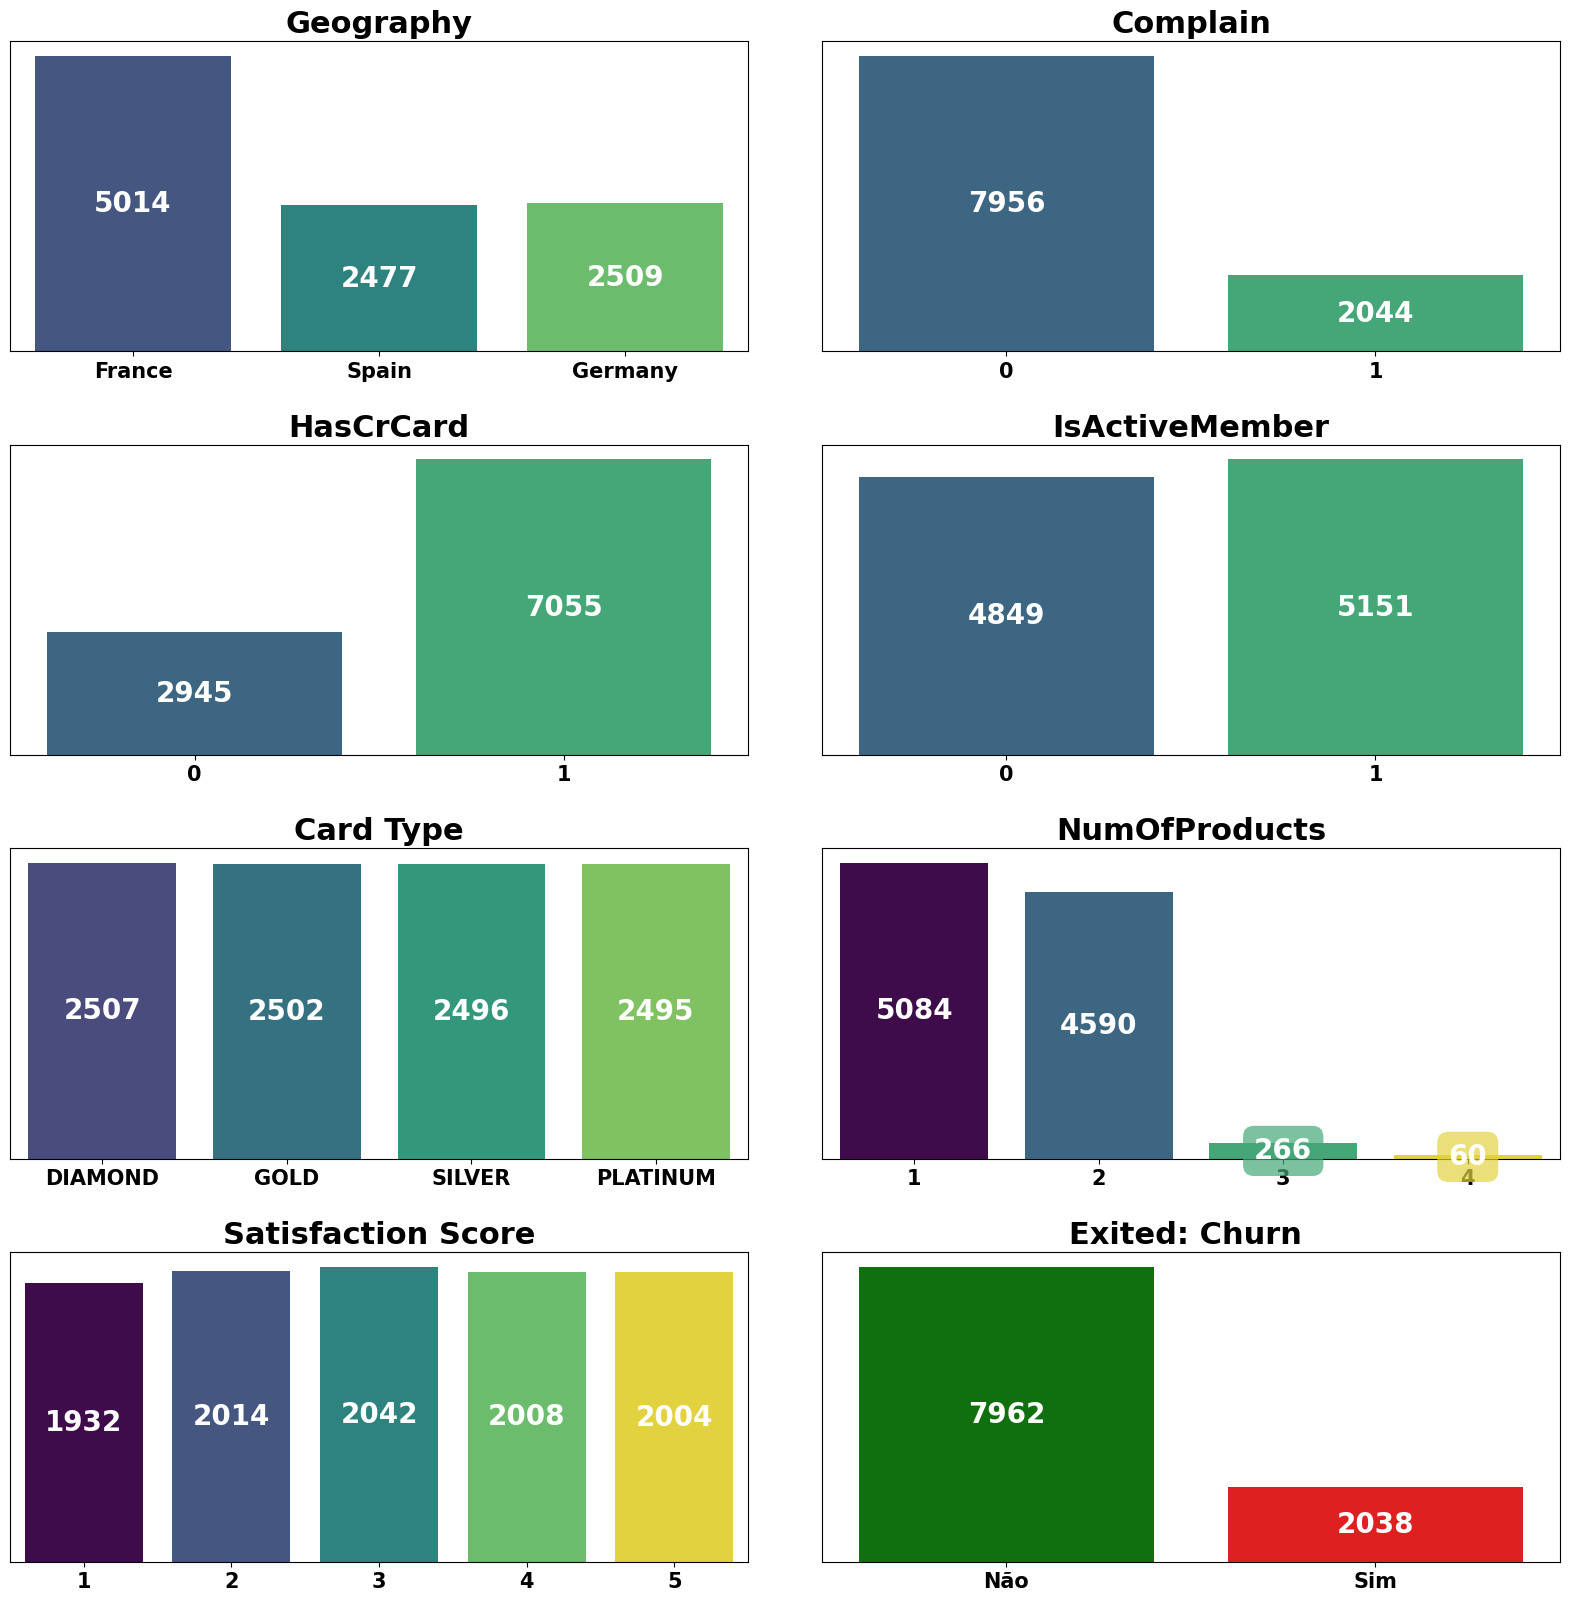

In [9]:
#Resumo estatistico 

#separando quali's para analise 
quali = df[['HasCrCard', 
            'IsActiveMember', 
            'Geography',
            #'Gender',
            'Complain',
            'Exited',
            'Card Type',
            'NumOfProducts',
            'Satisfaction Score']]

quali = quali.astype('object')

#quali.dtypes



def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)


# Complain
plt.subplot(5, 2, 2)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 3)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 4)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 5)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# NumOfProducts
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# Satisfaction Score
plt.subplot(5, 2, 7)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)






# Exited
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




* Visualizando o comportmento da variavel alvo (exited) em relacao as demais variaveis; 

* Vemos claramente que existe o disbalance de classes na variavel churn, pela cor verde presente fortemente em todas variaveis, posteriormente isso sera tratado/mitigado; 

* Ja e possivel notar um forte indicio de alta correlacao entre churn e complain, posteriormente isso sera testado. 



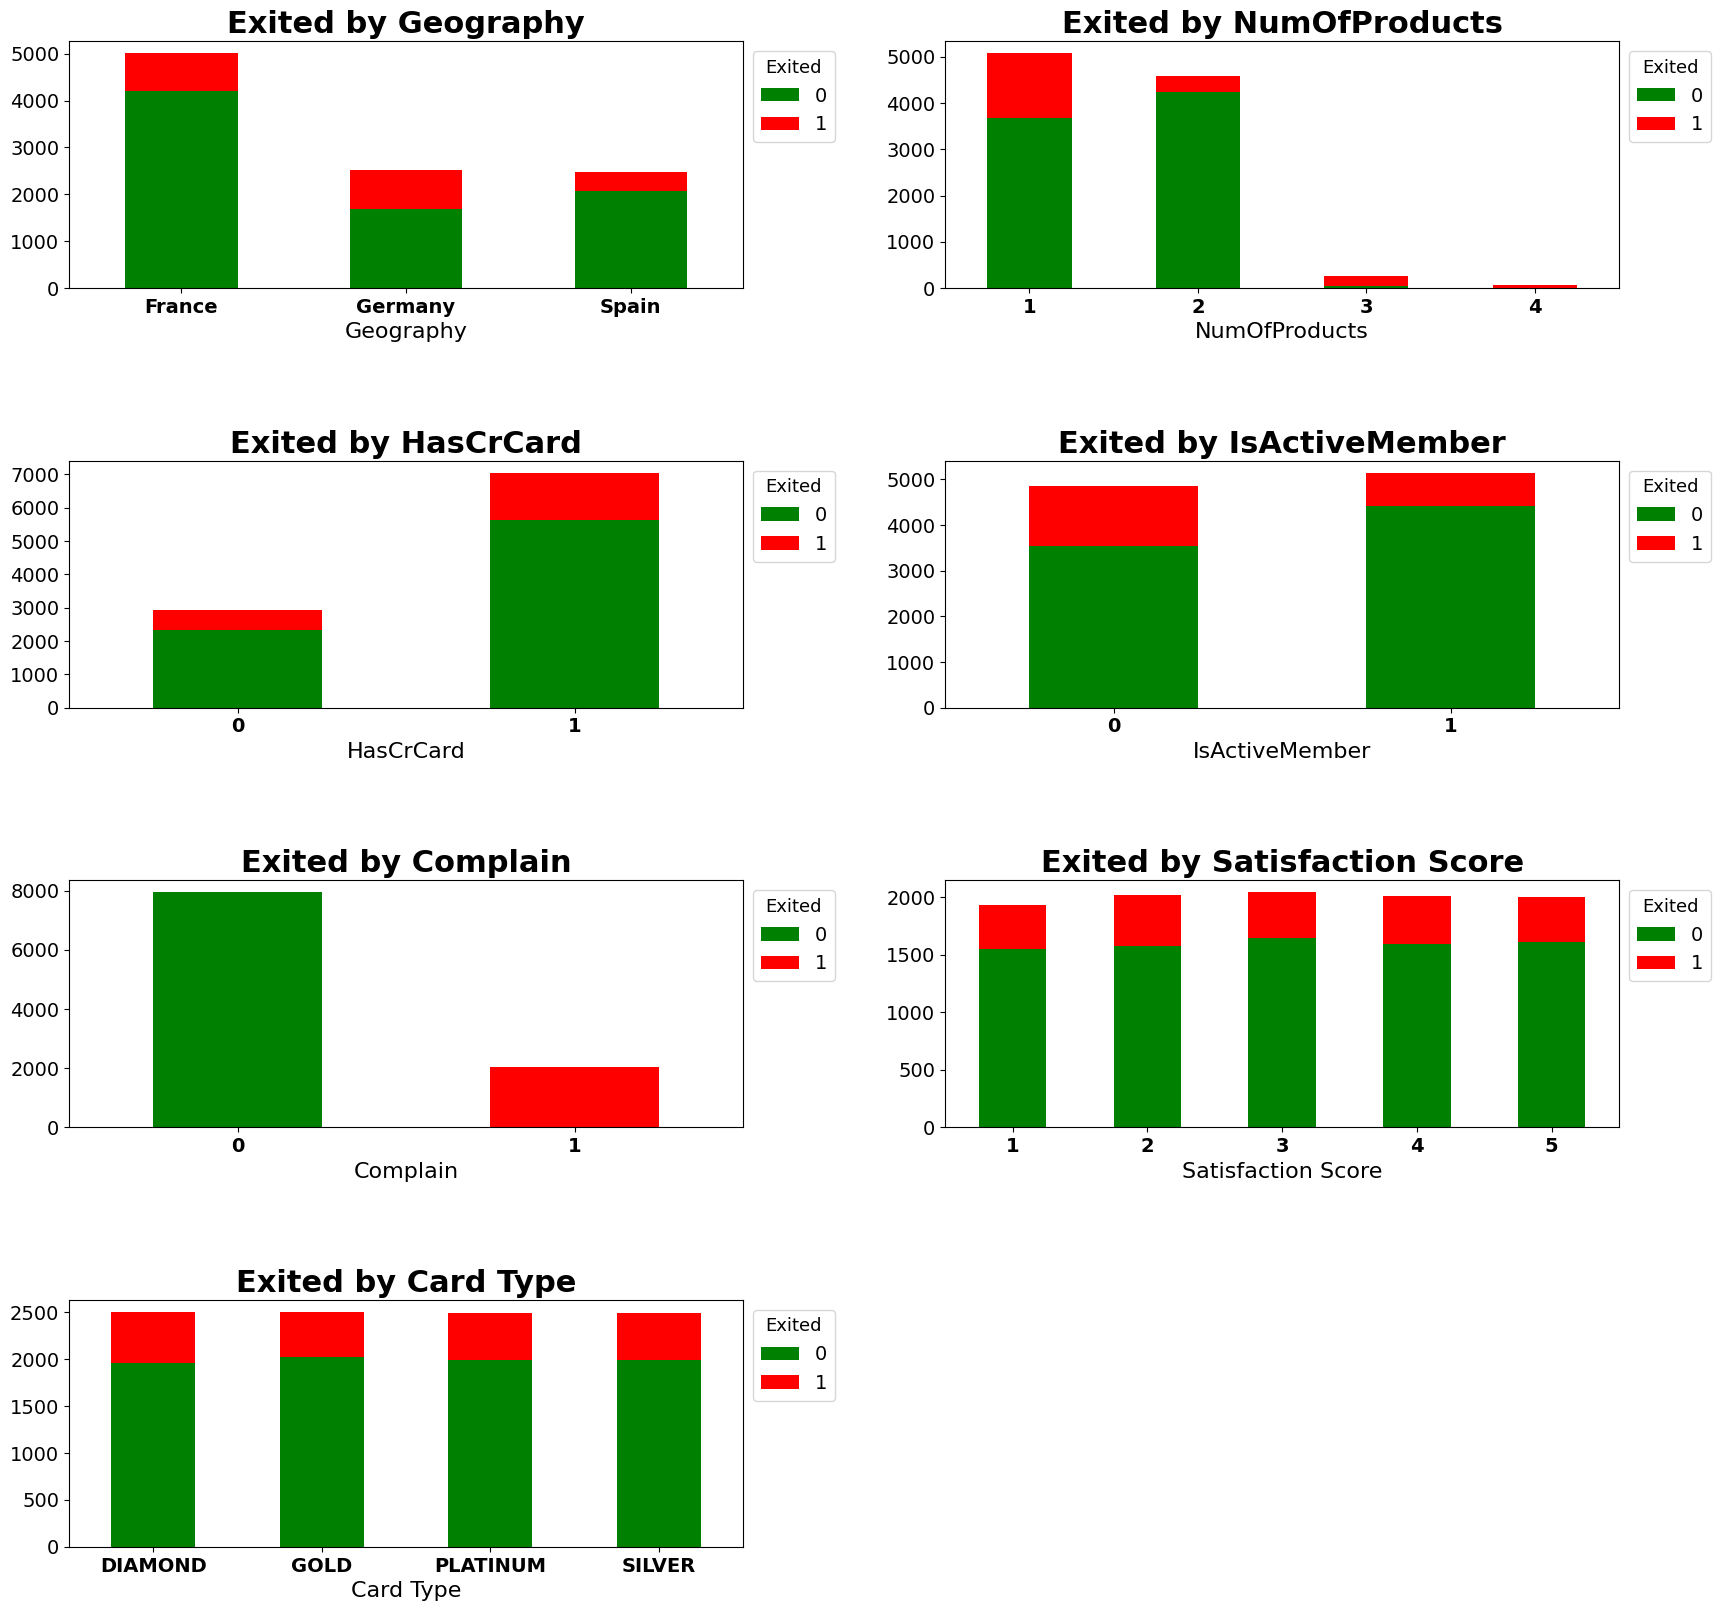

In [10]:
#%% Variável alvo em relação as demais variáveis 





plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 




# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)


# NumOfProducts
plt.subplot(5, 2, 2)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 3)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 4)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 5)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies

* A maioria dos modelos necessita de transformar as variaveis categoricas em numericas, e o modelo atual e um deles; 

* A transformacao de categoricas em numericas precisa ser feita com processos adequados para nao cometer ponderacao arbitrária no desenvolvimento. 

* foi aplicado one-hot encoding para isso. Esse processo e chamado de "Dummizacao". 

* foi necessario aplicar Ordinal-Encoder. 

In [11]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean)
warnings.filterwarnings('ignore', category=FutureWarning)

# Lista de variáveis a serem transformadas
cols_to_transform = ['Geography']

# Convertendo para string (somente a coluna "Geography")
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# Realizando o One-Hot Encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=True) 
#se o modelo/modelos forem afetados drasticamntee por multicolineariadde drop_first=True deve ser melhor, pois dropa uma das variaveis dummie. Os demais nao feta tanto, mas e boa pratica

# Ordinal-Encoder 
df_dummies['Card Type'] = OrdinalEncoder(categories=[["SILVER", "GOLD", "PLATINUM", "DIAMOND"]], dtype=int).fit_transform(df_dummies[['Card Type']])

# Variável alvo 'Exited' para o tipo numérico (se necessário)
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)

CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Card Type               int32
Point Earned            int64
Exited                  int64
Geography_Germany       int32
Geography_Spain         int32
dtype: object


# Separação Treino e Teste & Adicao de Features quadráticas

* A separacao em treino e teste alem de uma boa pratica e extreamente necessario na construcao de modelos de machine learning; 

* Tambem foram adicionadas variaveis quadraticas, ou seja, com operacao matematica aplicadas em variaveis originais gerando novas variaveis. Isso foi feito para capturar algum tipo de comportamento nao linear; 

* Foi considerado aplicar transformacao polinomial nas variaveis, por isso foi primeiro aplicado o termo quadratico, que nao apresentou melhoria significativa a ponto de aplicarmos polinomias; 

* Alem disso esse modelo captura naturalmente comportamentos nao lineares. O termo quadratico foi util para validacao durante o estudo mas a melhoria foi baixa, por isso mantemos apenas os termos quadraticos sem incluir interacoes entre variaveis (seria aplicacao Polinomias completo); 



* Tambem e possivel notar o desbalanceamento das classes  nas bases tanto em treino quanto em teste no grafico final; 

* Tambem garantimos a mesma proporcao (80/20) tanto em treino quanto em teste na separacao das bases , ou seja, equidade de divisao de dados e equilibrio. 


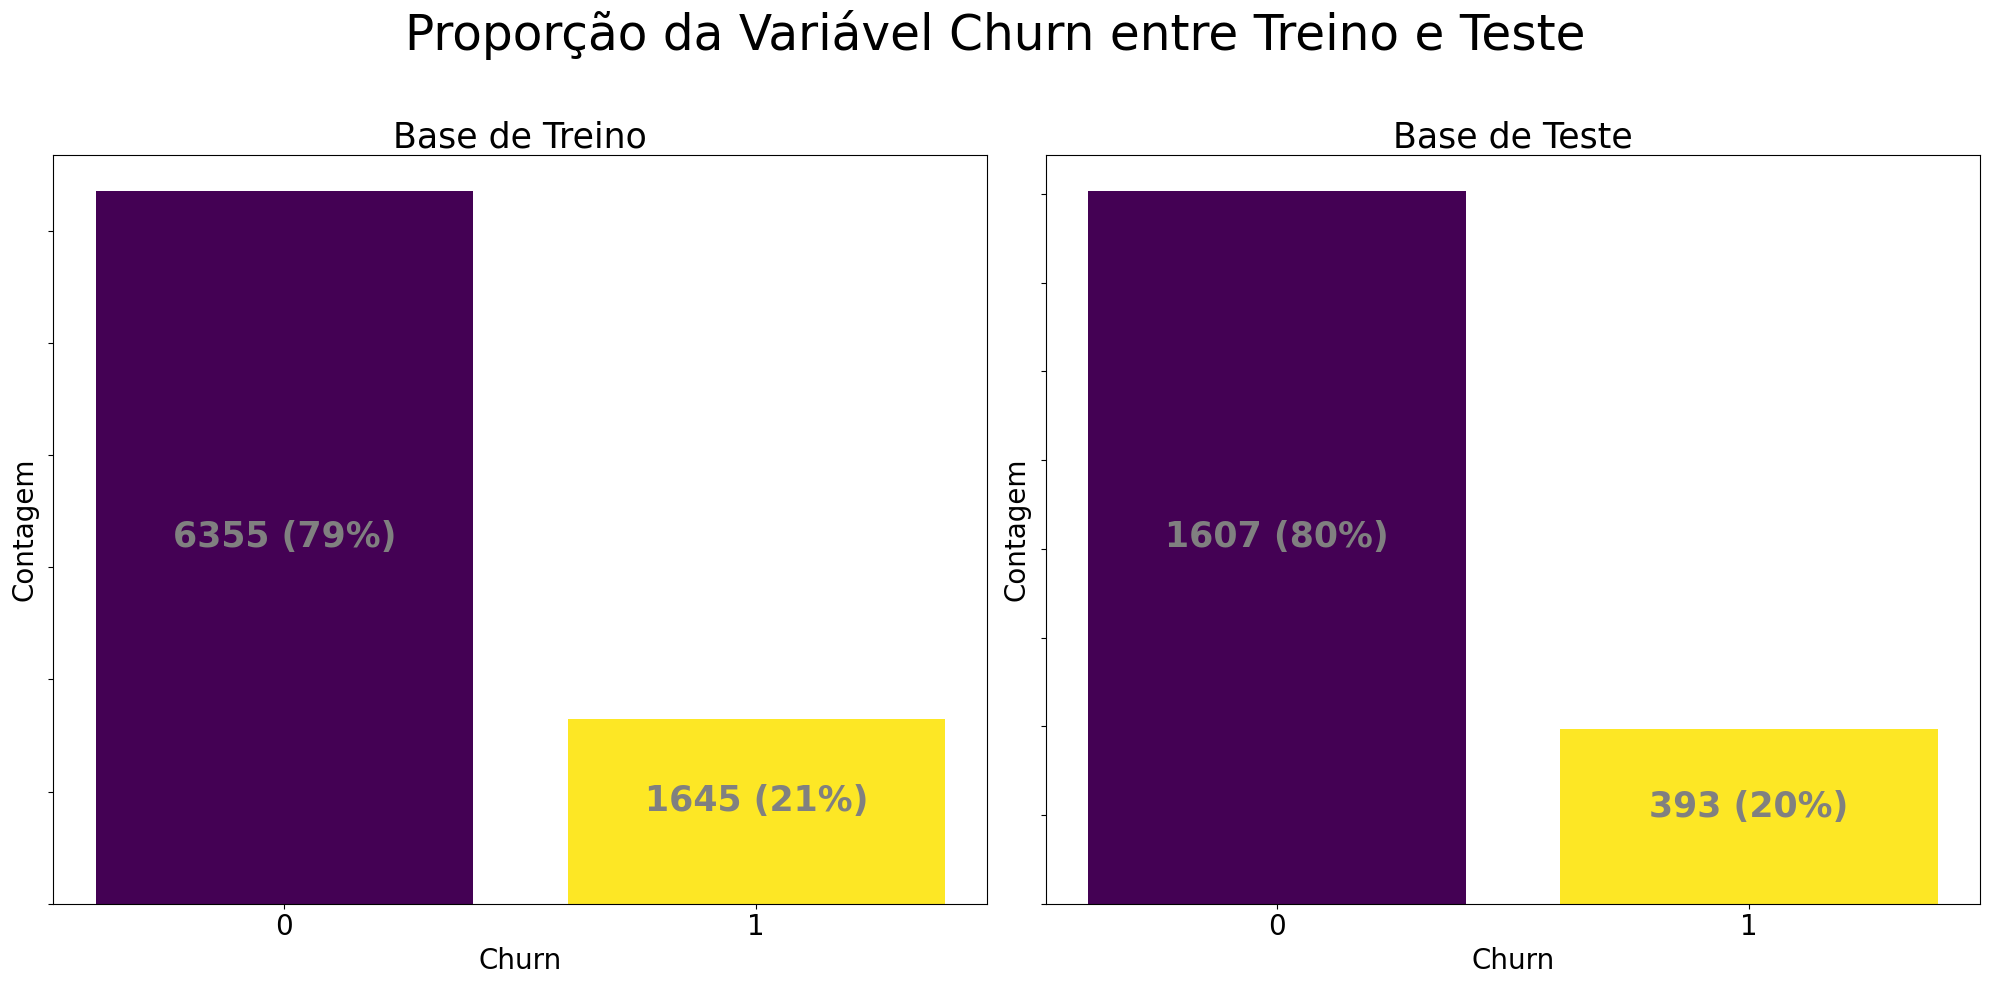

In [12]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)

df_dummies = df_dummies.drop(columns=['Complain']) #correlacao altissima com a variavel alvo


X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# plot que contem os graficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  
cmap = plt.get_cmap('viridis', 2) #paleta de cores



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
axs[0].set_yticklabels([]) # Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
axs[1].set_yticklabels([])# Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # forca espaco para o titulo
plt.show()




# Verificando correlacoes depois de construcao total de features e Dummizacao 

* Verificar as correlacoes e extreammente importante, elas podem indicar a famosa multicolinearidade, que atrapalha a maioria dos modelos; 

* no caso da deste modelo (pelo menos a presente aplicacao) ela nao afetou, a observei com atencao, mas nao impactou. Decidi manter as variveis mesmo com multicolinearidade em algumas (nao se assuste). 



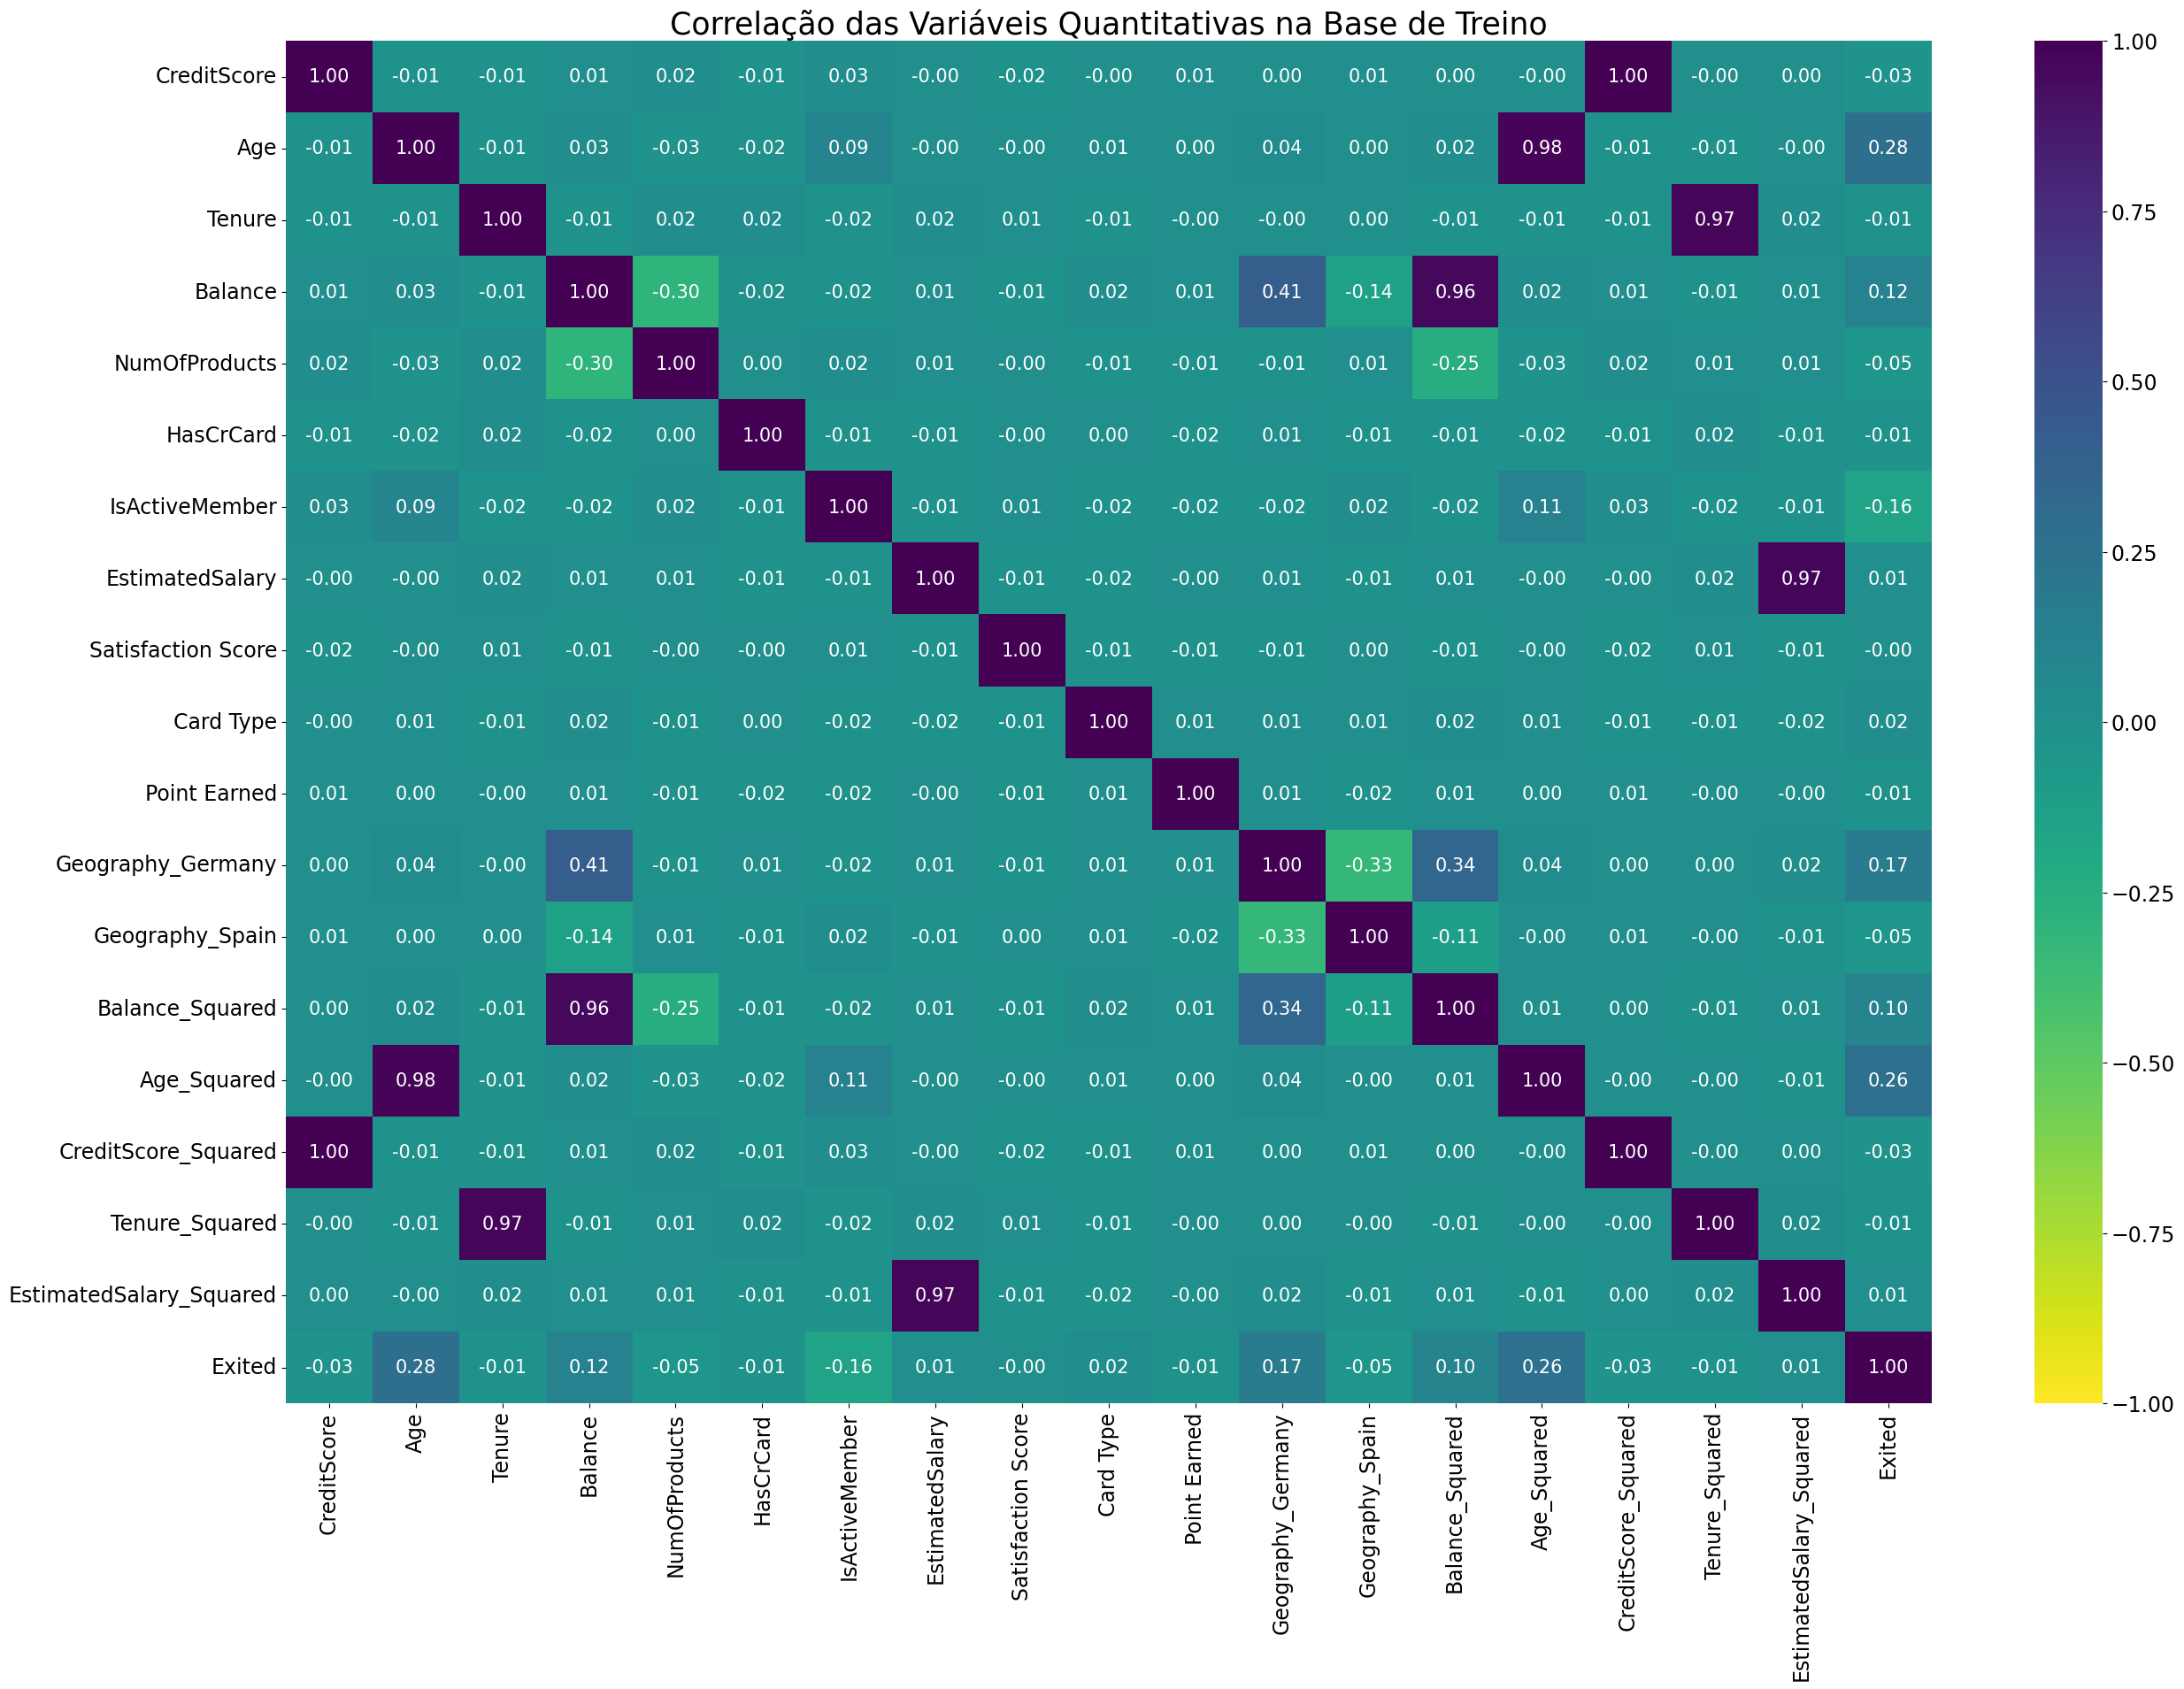

In [13]:
#Observando Multicolinearidade na base de treino

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

* Outliers sao numericos e podem afetar de diversas formas modelos; 

* para resolver sem perder dados, pois temos poucas observcoes para estudo, nao foram removidos como facilmente poderia fazer-se, ao inves foi aplicado winsorization; 

* winsorization e uma tecnica de limitacao dos outliers, ela substiui os valores de outlierns pelos limites superiores e inferiores; 

* Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3), valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 

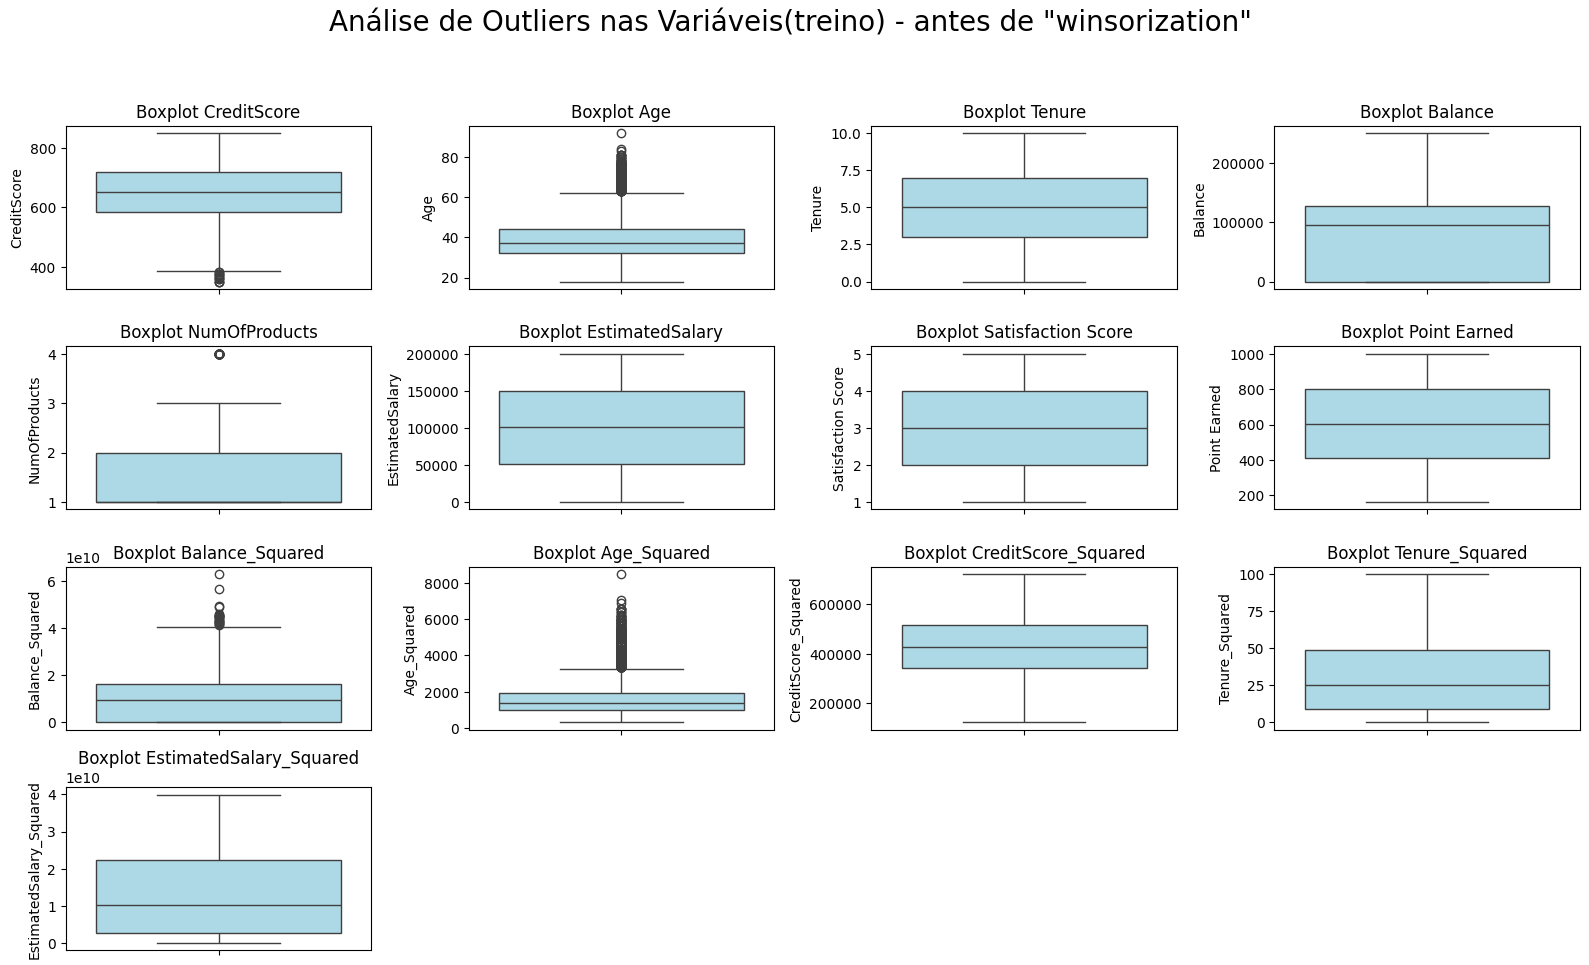

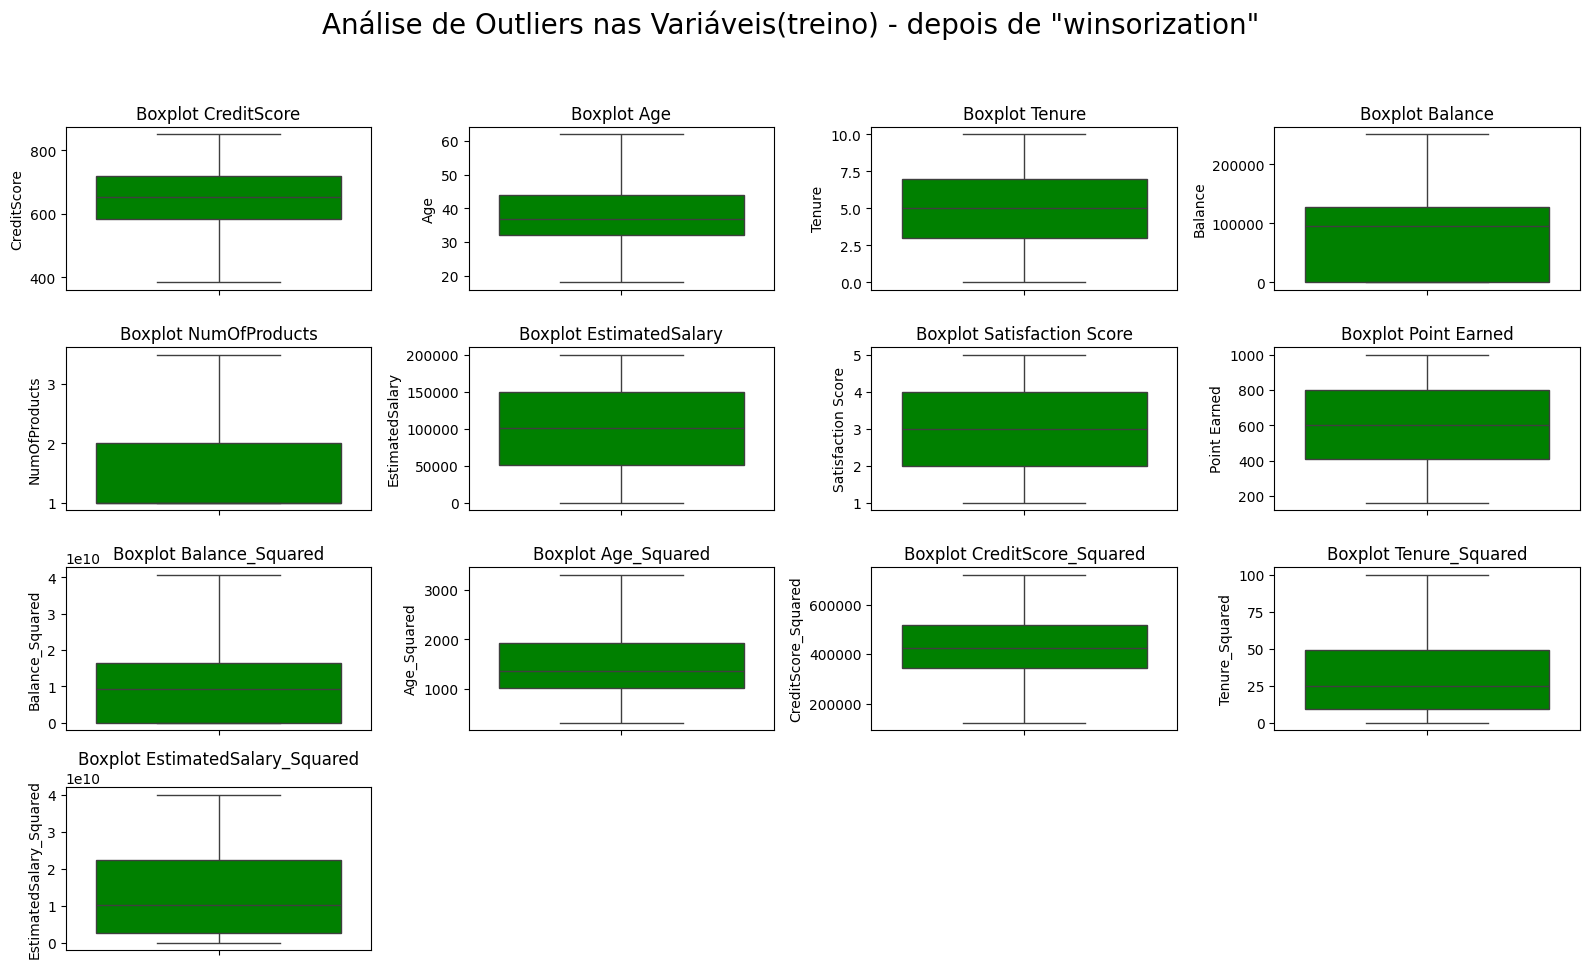

In [14]:
#%% analise de outliers das variaveis na base de treino 


###############antes de tratamento############################# 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'
]


# definindo tamnhos de subplots 
plt.figure(figsize=(16, 12))

# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot 
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste de layout
plt.show()
###############################################################






# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])





###############depois de tratamento############################# 

# Aplicando a função nas variáveis 
variaveis_para_tratar = ['CreditScore',
                        'Age',
                        'Tenure',
                        'Balance',
                        'NumOfProducts',
                        'EstimatedSalary',
                        'Satisfaction Score',
                        'Point Earned',
                        #QUADRATICAS
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot
    plt.title(f'Boxplot {var}', fontsize=12)
########################################################################


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ajusta layout
plt.show()

In [15]:
#BASE DE TREINO 
teste_multco_treino

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_Germany,Geography_Spain,Balance_Squared,Age_Squared,CreditScore_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
9254,686.0,32.0,6.0,0.00,2.0,1,1,179093.26,2.0,3,510.0,0,0,0.000000e+00,1024.0,470596.0,36.0,3.207440e+10,0
1561,632.0,42.0,4.0,119624.60,2.0,1,1,195978.86,4.0,2,959.0,1,0,1.431004e+10,1764.0,399424.0,16.0,3.840771e+10,0
1670,559.0,24.0,3.0,114739.92,1.0,1,0,85891.02,4.0,0,327.0,0,1,1.316525e+10,576.0,312481.0,9.0,7.377267e+09,1
6087,561.0,27.0,9.0,135637.00,1.0,1,0,153080.40,2.0,0,567.0,0,0,1.839740e+10,729.0,314721.0,81.0,2.343361e+10,1
6669,517.0,56.0,9.0,142147.32,1.0,0,0,39488.04,3.0,2,727.0,0,0,2.020586e+10,3136.0,267289.0,81.0,1.559305e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768.0,54.0,8.0,69712.74,1.0,1,1,69381.05,3.0,0,569.0,0,0,4.859866e+09,2916.0,589824.0,64.0,4.813730e+09,0
5191,682.0,58.0,1.0,0.00,1.0,1,1,706.50,4.0,2,709.0,0,0,0.000000e+00,3304.0,465124.0,1.0,4.991422e+05,0
5390,735.0,38.0,1.0,0.00,3.0,0,0,92220.12,5.0,0,678.0,0,0,0.000000e+00,1444.0,540225.0,1.0,8.504551e+09,1
860,667.0,43.0,8.0,190227.46,1.0,1,0,97508.04,3.0,3,680.0,0,0,3.618649e+10,1849.0,444889.0,64.0,9.507818e+09,1


In [16]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_Germany,Geography_Spain,Balance_Squared,Age_Squared,CreditScore_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
6252,596,32,3,96709.07,2,0,0,41788.37,1,1,709,1,0,9.352644e+09,1024,355216,9,1.746268e+09,0
4684,623,43,1,0.00,2,1,1,146379.30,2,0,508,0,0,0.000000e+00,1849,388129,1,2.142690e+10,0
1731,601,44,4,0.00,2,1,0,58561.31,1,1,281,0,1,0.000000e+00,1936,361201,16,3.429427e+09,0
4742,506,59,8,119152.10,2,1,1,170679.74,2,0,979,1,0,1.419722e+10,3481,256036,64,2.913157e+10,0
4521,560,27,7,124995.98,1,1,1,114669.79,5,0,457,0,1,1.562400e+10,729,313600,49,1.314916e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,602,53,5,98268.84,1,0,1,45038.29,5,2,813,1,0,9.656765e+09,2809,362404,25,2.028448e+09,1
8285,609,25,10,0.00,1,0,1,109895.16,2,2,652,0,0,0.000000e+00,625,370881,100,1.207695e+10,0
7853,730,47,7,0.00,1,1,0,33373.26,2,2,504,0,0,0.000000e+00,2209,532900,49,1.113774e+09,1
1095,692,29,4,0.00,1,1,0,76755.99,3,2,686,0,0,0.000000e+00,841,478864,16,5.891482e+09,1


# Preparacao dos dados  


* Preparacao dos dados 


------------------------
 DATA Prep
------------------------
------------------------
Início: 2025-03-21 01:58:30.510457
------------------------
Índices de X_test e y_test já estavam alinhados.


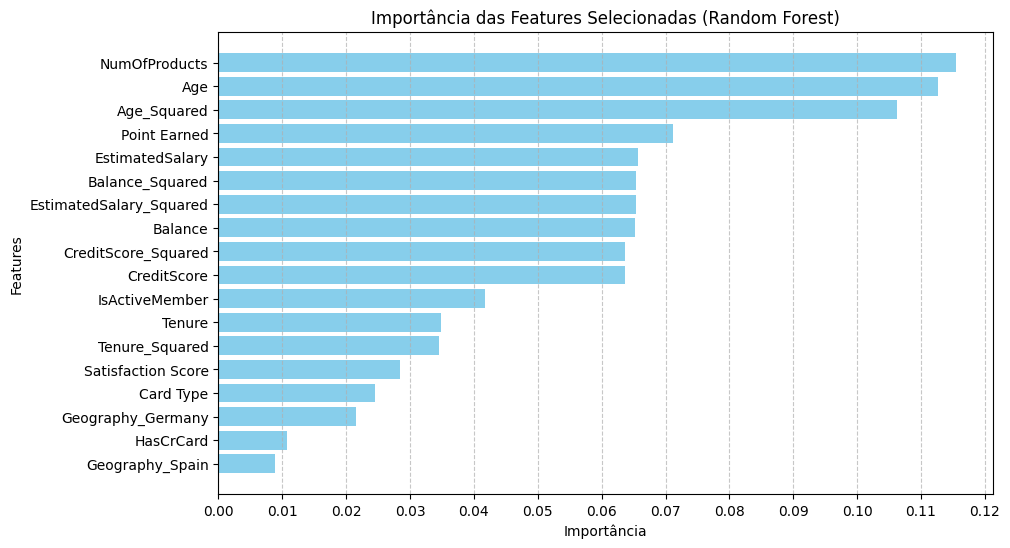

In [17]:
print('------------------------')
print(" DATA Prep")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 



# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']

# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis 
#detalhe importante, nao tem predict(), somente o fit() 
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))


# Mostrar o gráfico
plt.show()




# Finalizando preparacao e selecionando variaveis

Variaveis selecionadas conforme o modelo classificador de importancia usado anteriormente (randomforest) 

In [18]:

print("Shape X_train antes de selecionar as fetuares importantes:", X_train.shape)
print("Shape y_train antes de selecionar as fetuares importantes:", y_train.shape)


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


start_time_utc = datetime.utcnow() - timedelta(hours=3)
print("Tempo de Início:", start_time_utc)
print('------------------------')


X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train, y_train = X_train_selected , y_train
X_test, y_test = X_test_selected , y_test

print("Shape X_train (selecionadas):", X_train.shape)
print("Shape y_train (selecionadas):", y_train.shape)

print("Shape X_test (selecionadas):", X_test.shape)
print("Shape y_test (selecionadas):", y_test.shape)


#verificando alinhamneto
assert X_train.shape[0] == y_train.shape[0], "Erro: Número de amostras não coincide"
assert X_test.shape[0] == y_test.shape[0], "Erro: Número de amostras não coincide"


Shape X_train antes de selecionar as fetuares importantes: (8000, 18)
Shape y_train antes de selecionar as fetuares importantes: (8000,)
Tempo de Início: 2025-03-21 01:58:36.033316
------------------------
Shape X_train (selecionadas): (8000, 17)
Shape y_train (selecionadas): (8000,)
Shape X_test (selecionadas): (2000, 17)
Shape y_test (selecionadas): (2000,)


# **Ensemble Model - Aplicando modelos treinados e salvos anteriormente (olhar repositorio)** 

Arquivo scaler_mlp_temp.pkl removido com sucesso.

📊 MÉTRICAS DO MODELO MLP nos dados de teste
Métrica             Valor final    
------------------------------------------------------------
Acurácia           0.8545
Precisão            0.6281
Recall              0.6361
F1-Score            0.6321
AUC-ROC             0.8562
MCC                 0.5415
Kappa de Cohen       0.5414
Acurácia Balanceada 0.7720


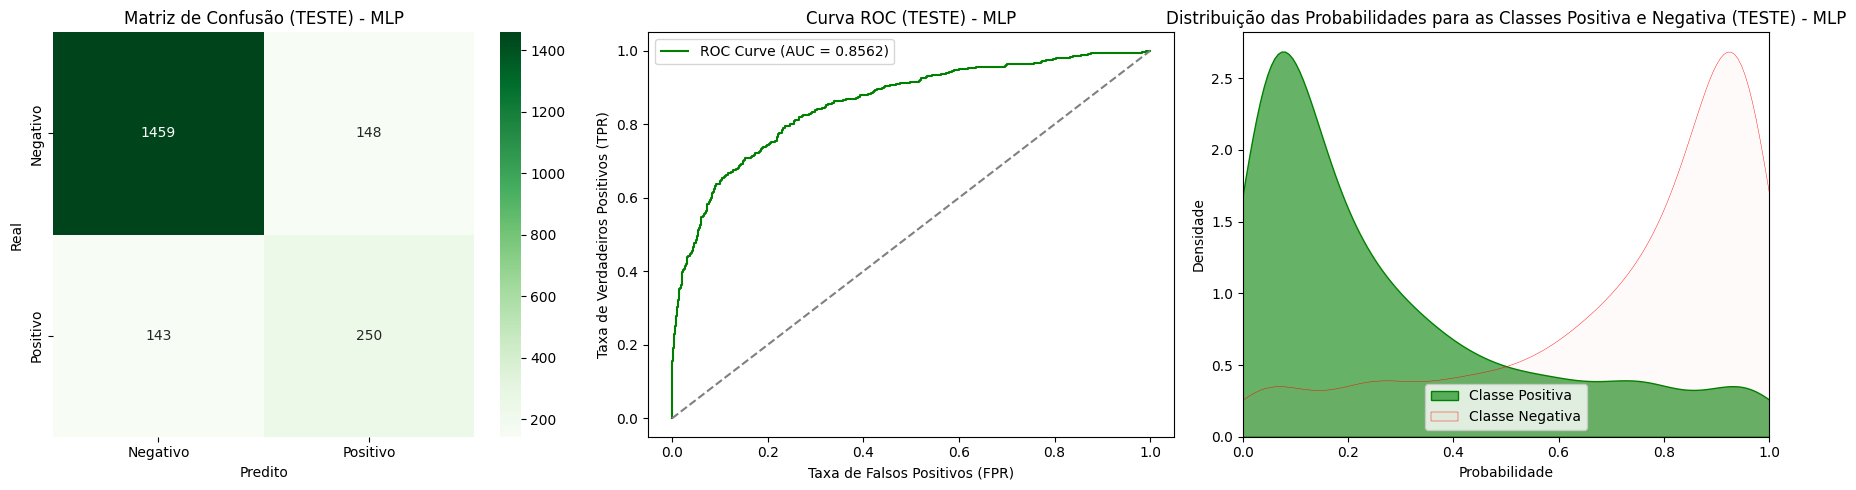

In [19]:
# MLP - PyTorch

# Classe MLP do modelo (reconstrução exata)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, activation, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for units in hidden_layer_sizes:
            self.layers.append(nn.Linear(input_size, units))
            self.layers.append(nn.Dropout(p=dropout_rate))
            input_size = units
        self.output = nn.Linear(input_size, 1)
        self.activation_fn = self.get_activation_function(activation)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        x = self.output(x)
        return x

    def get_activation_function(self, activation):
        activation_dict = {
            'relu': torch.relu,
            'tanh': torch.tanh,
            'sigmoid': torch.sigmoid,
            'selu': torch.selu,
            'gelu': torch.nn.functional.gelu,
            'leaky_relu': torch.nn.functional.leaky_relu,
            'swish': torch.nn.functional.silu,
            'elu': torch.nn.functional.elu
        }
        return activation_dict.get(activation, torch.relu)

# Definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o scaler
scaler_mlp_torch = torch.load(r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\MLP-Pytorch\scaler.pth")

#salvando para uso dentro desse notebook, uma copia com formato de joblib / pickle
joblib.dump(scaler_mlp_torch, "scaler_mlp_temp.pkl")

#definindo scaler definitivamente
scaler_mlp_torch = joblib.load("scaler_mlp_temp.pkl")


#apagando scaler_mlp_temp para nao confundir com scaler scaler oficial do ensemble

arquivo = "scaler_mlp_temp.pkl"
if os.path.exists(arquivo):
    os.remove(arquivo)
    print(f"Arquivo {arquivo} removido com sucesso.")
else:
    print(f"Arquivo {arquivo} não encontrado.")



# Normalizar os dados de teste
X_test_scaled = scaler_mlp_torch.transform(X_test)

# Converter X_test para tensor do PyTorch
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Carregar os hiperparâmetros do modelo 
hidden_layer_sizes = [950, 850]  # com base nos melhores parâmetros encontrados no modelo carregado e treinado anteriormente 
activation = "relu"  # com base nos melhores parâmetros encontrados no modelo carregado e treinado anteriormente 
dropout_rate = 0.35657230019086544  # com base nos melhores parâmetros encontrados no modelo carregado e treinado anteriormente 

# Criar a instância do modelo com os hiperparâmetros corretos
input_size = X_test.shape[1]
model_mlp_torch = MLP(input_size, hidden_layer_sizes, activation, dropout_rate)

# Carregar o modelo salvo
model_mlp_torch = torch.load(r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\MLP-Pytorch\best_model_inteiro.pth", map_location=device)
model_mlp_torch.to(device)
model_mlp_torch.eval()

# Fazer previsões
with torch.no_grad():
    # Aplicar a função sigmoide 
    y_pred_proba = torch.sigmoid(model_mlp_torch(X_test_tensor)).cpu().numpy().flatten()

# Converter probabilidades para rótulos binários (0 ou 1)
y_pred = (y_pred_proba >= 0.5).astype(int)


# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Exibir as métricas no formato desejado
print("\n📊 MÉTRICAS DO MODELO MLP nos dados de teste")
print("=" * 60)
print(f"{'Métrica':<20}{'Valor final':<15}")
print("-" * 60)
print(f"Acurácia{' ' * 11}{accuracy:.4f}")
print(f"Precisão{' ' * 12}{precision:.4f}")
print(f"Recall{' ' * 14}{recall:.4f}")
print(f"F1-Score{' ' * 12}{f1:.4f}")
print(f"AUC-ROC{' ' * 13}{auc_roc:.4f}")
print(f"MCC{' ' * 17}{mcc:.4f}")
print(f"Kappa de Cohen{' ' * 7}{kappa:.4f}")
print(f"Acurácia Balanceada {balanced_acc:.4f}")
print("=" * 60)

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"], ax=axes[0])
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de Confusão (TESTE) - MLP")

# Plot da Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_roc_value = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc_value:.4f})", color="Green")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal
axes[1].set_xlabel("Taxa de Falsos Positivos (FPR)")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos (TPR)")
axes[1].set_title("Curva ROC (TESTE) - MLP")
axes[1].legend()

# Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_proba  
# classe negativa
probs_neg = 1 - y_pred_proba

# Plot classe positiva 
sns.kdeplot(probs_pos, color='green', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)

# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)

# Ajustando o gráfico
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - MLP")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)

# Ajuste de layout
plt.tight_layout()
plt.show()




📊 MÉTRICAS DO MODELO XGBOOST nos dados de teste
Métrica                Valor final    
------------------------------------------------------------
Acurácia               0.8425
Precisão               0.5841
Recall                 0.6896
F1-Score               0.6324
AUC-ROC                0.8654
MCC                    0.5361
Kappa de Cohen         0.5331
Acurácia Balanceada    0.7847


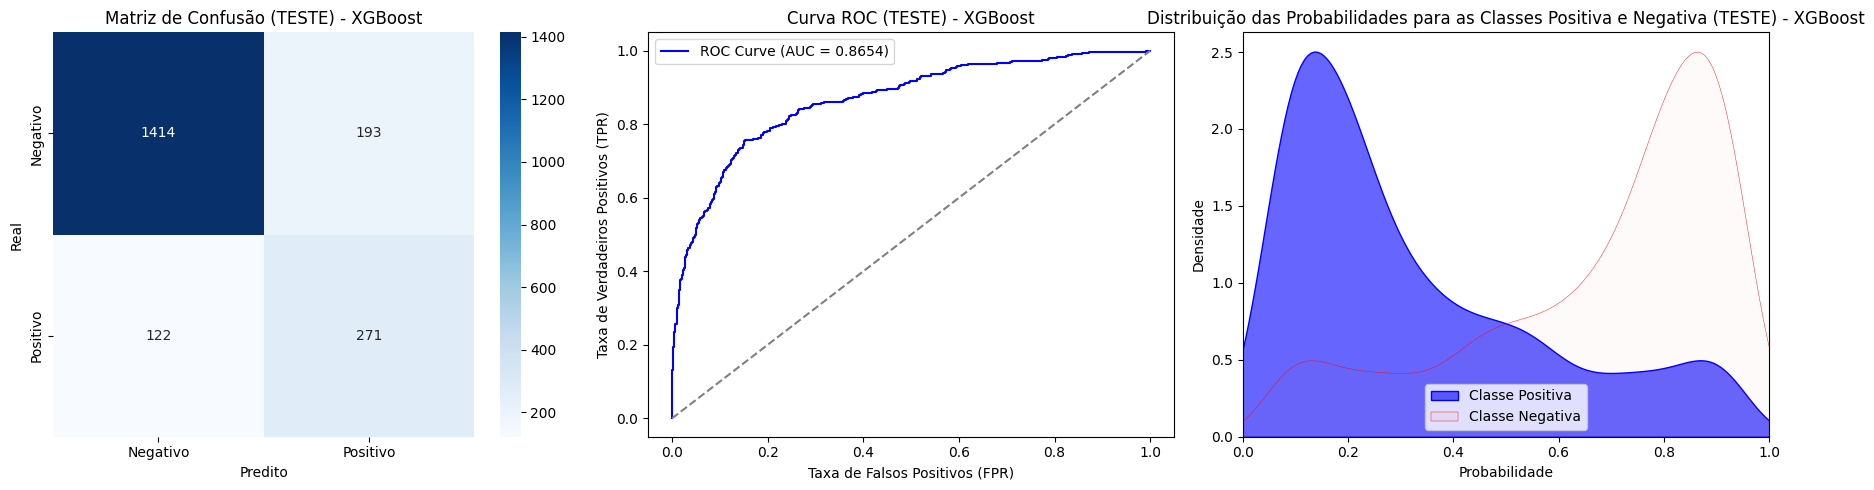

In [20]:
# XGBoost 
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Caminhos dos arquivos
model_path = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Xgboost\xgb_model.pkl"
scaler_path = r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\Xgboost\scaler.pkl"

# Carregar o scaler
scaler_xgb = joblib.load(scaler_path)

# Normalizar os dados de teste
X_test_scaled = scaler_xgb.transform(X_test)

# Carregar o modelo XGBoost
xgb_model = joblib.load(model_path)

# Fazer previsões (probabilidades)
y_pred_prob = xgb_model.predict(xgb.DMatrix(X_test_scaled))

# Converter para classe binária (usando threshold 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Exibir métricas no formato esperado
print("\n📊 MÉTRICAS DO MODELO XGBOOST nos dados de teste")
print("="*60)
print(f"{'Métrica':<22} {'Valor final':<15}")
print("-"*60)
print(f"{'Acurácia':<22} {accuracy:.4f}")
print(f"{'Precisão':<22} {precision:.4f}")
print(f"{'Recall':<22} {recall:.4f}")
print(f"{'F1-Score':<22} {f1:.4f}")
print(f"{'AUC-ROC':<22} {roc_auc:.4f}")
print(f"{'MCC':<22} {mcc:.4f}")
print(f"{'Kappa de Cohen':<22} {kappa:.4f}")
print(f"{'Acurácia Balanceada':<22} {balanced_acc:.4f}")
print("="*60)

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"], ax=axes[0])
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de Confusão (TESTE) - XGBoost")

# Plot da Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_value:.4f})", color="blue")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal
axes[1].set_xlabel("Taxa de Falsos Positivos (FPR)")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos (TPR)")
axes[1].set_title("Curva ROC (TESTE) - XGBoost")
axes[1].legend()

# Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_prob  
# classe negativa
probs_neg = 1 - y_pred_prob

# Plot classe positiva 
sns.kdeplot(probs_pos, color='blue', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)

# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)

# Ajustando o gráfico
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - XGBoost")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)


# Ajuste de layout
plt.tight_layout()
plt.show()

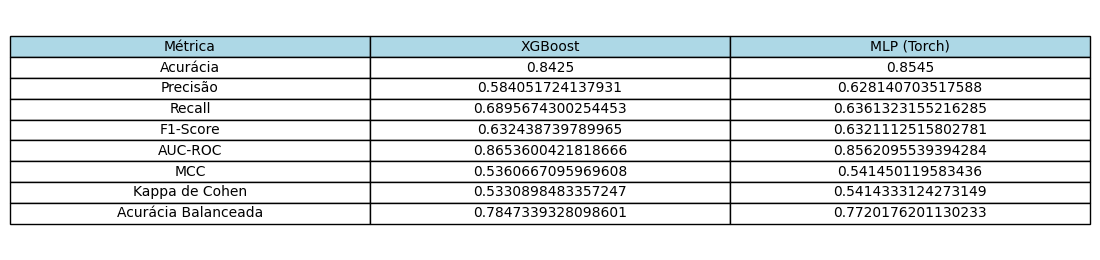

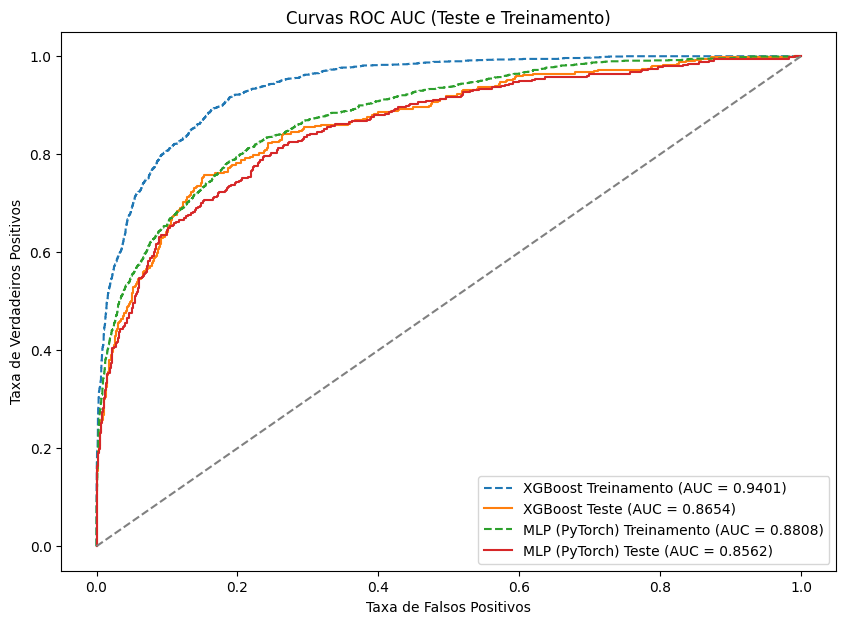

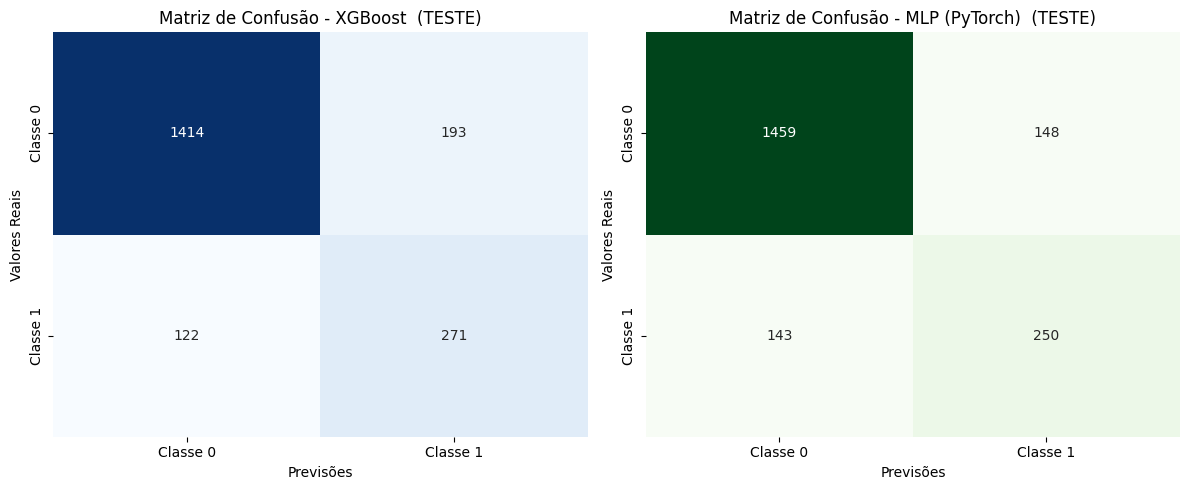

In [21]:
# ----------------------------------------------------------
# 1. XGBoost
# ----------------------------------------------------------

# XGBoost - normalizando com o scaler específico para XGBoost
X_train_scaled_xgb = scaler_xgb.transform(X_train)
X_test_scaled_xgb = scaler_xgb.transform(X_test)


# Conjunto de treino
# Previsões no conjunto de treino
y_pred_prob_xgb_ensemble_train = xgb_model.predict(xgb.DMatrix(X_train_scaled_xgb))

# Conjunto de teste
# Fazer previsões (probabilidades)
y_pred_prob_xgb_ensemble_test = xgb_model.predict(xgb.DMatrix(X_test_scaled_xgb))

# Converter para classe binária (usando threshold 0.5)
xgb_y_pred_xgb_ensemble_test_ = (y_pred_prob_xgb_ensemble_test >= 0.5).astype(int)

# Calcular as métricas
xgb_ensemble_accuracy = accuracy_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_precision = precision_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_recall = recall_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_f1 = f1_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_auc_roc = roc_auc_score(y_test, y_pred_prob_xgb_ensemble_test)  # Correção aqui
xgb_ensemble_mcc = matthews_corrcoef(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_kappa = cohen_kappa_score(y_test, xgb_y_pred_xgb_ensemble_test_)
xgb_ensemble_balanced_acc = balanced_accuracy_score(y_test, xgb_y_pred_xgb_ensemble_test_)

# ----------------------------------------------------------
# 2. MLP (Torch)
# ----------------------------------------------------------

# normalizando MLP com o scaler específico para MLP
X_train_scaled_mlp = scaler_mlp_torch.transform(X_train)
X_test_scaled_mlp = scaler_mlp_torch.transform(X_test)


# Converter para tensor do PyTorch
X_train_tensor = torch.tensor(X_train_scaled_mlp, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled_mlp, dtype=torch.float32).to(device)

# Criar a instância do modelo com os hiperparâmetros corretos
input_size = X_test.shape[1]
model_mlp_torch = MLP(input_size, hidden_layer_sizes, activation, dropout_rate)

# Carregar o modelo salvo
model_mlp_torch = torch.load(r"C:\Users\jgeov\OneDrive\Documentos\GitHub\Ciencia_de_dados-1\Churn_predict\MLP-Pytorch\best_model_inteiro.pth", map_location=device)
model_mlp_torch.to(device)
model_mlp_torch.eval()

# Fazer previsões para os dados de teste
with torch.no_grad():
    # Aplicar a função sigmoide para garantir que as probabilidades estão no intervalo [0, 1]
    y_pred_proba_mlp_ensemble_test = torch.sigmoid(model_mlp_torch(X_test_tensor)).cpu().numpy().flatten()

# Converter probabilidades para rótulos binários (0 ou 1) no conjunto de teste
y_pred_mlp_ensemble_test_ = (y_pred_proba_mlp_ensemble_test >= 0.5).astype(int)

# Fazer previsões para os dados de treino
with torch.no_grad():
    # Aplicar a função sigmoide para garantir que as probabilidades estão no intervalo [0, 1]
    y_pred_proba_mlp_ensemble_train = torch.sigmoid(model_mlp_torch(X_train_tensor)).cpu().numpy().flatten()

# Converter probabilidades para rótulos binários (0 ou 1) no conjunto de treino
y_pred_mlp_ensemble_train_ = (y_pred_proba_mlp_ensemble_train >= 0.5).astype(int)

# Agora, temos as probabilidades e as classes para treino e teste

# Calcular as métricas
mlp_ensemble_accuracy = accuracy_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_precision = precision_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_recall = recall_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_f1 = f1_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_auc_roc = roc_auc_score(y_test, y_pred_proba_mlp_ensemble_test)  # AUC-ROC agora usando as probabilidades (não as classes)
mlp_ensemble_mcc = matthews_corrcoef(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_kappa = cohen_kappa_score(y_test, y_pred_mlp_ensemble_test_)
mlp_ensemble_balanced_acc = balanced_accuracy_score(y_test, y_pred_mlp_ensemble_test_)



# ----------------------------------------------------------
# Exibir as métricas para os modelos - criando tabela de plot 
# ----------------------------------------------------------

# Dados das métricas de cada modelo
data = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC', 'MCC', 'Kappa de Cohen', 'Acurácia Balanceada'],
    'XGBoost': [xgb_ensemble_accuracy, xgb_ensemble_precision, xgb_ensemble_recall, xgb_ensemble_f1, xgb_ensemble_auc_roc, 
                xgb_ensemble_mcc, xgb_ensemble_kappa, xgb_ensemble_balanced_acc],
    'MLP (Torch)': [mlp_ensemble_accuracy, mlp_ensemble_precision, mlp_ensemble_recall, mlp_ensemble_f1, mlp_ensemble_auc_roc, 
                    mlp_ensemble_mcc, mlp_ensemble_kappa, mlp_ensemble_balanced_acc]
}

# Criando df
metrics_df = pd.DataFrame(data)

# Plotando a tabela 
fig, ax = plt.subplots(figsize=(10, 3)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, 
                 colLabels=metrics_df.columns, 
                 cellLoc='center', loc='center', 
                 colColours=["lightblue"]*4)

# Ajustando os parâmetros 
table.auto_set_font_size(False)  # Não usar o tamanho automático da fonte
table.set_fontsize(10)  # tamanho da fonte
table.scale(1.2, 1.2)  # tamanho da tabela

# ajuste de layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

plt.show()




# ----------------------------------------------------------
# Plotando as Curvas ROC AUC dos modelos (treino e teste)
# ----------------------------------------------------------

plt.figure(figsize=(10, 7))

# ROC Curve - XGBoost (Treinamento)
fpr_xgb_train, tpr_xgb_train, _ = roc_curve(y_train, xgb_model.predict(xgb.DMatrix(X_train_scaled_xgb)))
plt.plot(fpr_xgb_train, tpr_xgb_train, label=f"XGBoost Treinamento (AUC = {roc_auc_score(y_train, xgb_model.predict(xgb.DMatrix(X_train_scaled_xgb))):.4f})", linestyle='--')

# ROC Curve - XGBoost (teste)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb_ensemble_test)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost Teste (AUC = {xgb_ensemble_auc_roc:.4f})")


# ROC Curve - MLP (PyTorch)  (Treinamento)
fpr_mlp_train, tpr_mlp_train, _ = roc_curve(y_train, model_mlp_torch(torch.tensor(X_train_scaled_mlp, dtype=torch.float32).to(device)).cpu().detach().numpy())
plt.plot(fpr_mlp_train, tpr_mlp_train, label=f"MLP (PyTorch) Treinamento (AUC = {roc_auc_score(y_train, model_mlp_torch(torch.tensor(X_train_scaled_mlp, dtype=torch.float32).to(device)).cpu().detach().numpy()):.4f})", linestyle='--')

# ROC Curve - MLP (PyTorch) (teste)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp_ensemble_test)
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (PyTorch) Teste (AUC = {mlp_ensemble_auc_roc:.4f})")


# Linha de Chance
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Linha diagonal


plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curvas ROC AUC (Teste e Treinamento)")
plt.legend(loc="lower right")
plt.show()



# ----------------------------------------------------------
# Plotar as Matrizes de Confusão dos modelos em Subplots
# ----------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - XGBoost (nos dados de teste)
xgb_cm = confusion_matrix(y_test, xgb_y_pred_xgb_ensemble_test_)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0], 
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
axes[0].set_title("Matriz de Confusão - XGBoost  (TESTE)")
axes[0].set_xlabel('Previsões')
axes[0].set_ylabel('Valores Reais')

# Matriz de Confusão - MLP nos (dados de teste)
mlp_cm = confusion_matrix(y_test, y_pred_mlp_ensemble_test_)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1], 
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
axes[1].set_title("Matriz de Confusão - MLP (PyTorch)  (TESTE)")
axes[1].set_xlabel('Previsões')
axes[1].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()


# Construção de Modelo final (meta model)
* Adicionando variaveis de probabilidades preditas dos modelos base no dataset para o META MODEL 

In [22]:
# ------------------------------------------------------
# Gerar previsões dos modelos (predicoes separadas)
# ------------------------------------------------------

# Criar DataFrames de treino e teste para as previsões
df_predicoes_train = pd.DataFrame({
    'XGBoost_Prob': y_pred_prob_xgb_ensemble_train,
    'MLP_Torch_Prob': y_pred_proba_mlp_ensemble_train,
}, index=X_train.index)  # Mantendo o mesmo índice do X_train

df_predicoes_test = pd.DataFrame({
    'XGBoost_Prob': y_pred_prob_xgb_ensemble_test,
    'MLP_Torch_Prob': y_pred_proba_mlp_ensemble_test,
}, index=X_test.index)  # Mantendo o mesmo índice do X_test

# Concatenar com os datasets originais
X_train_stacking = pd.concat([X_train, df_predicoes_train], axis=1)
X_test_stacking = pd.concat([X_test, df_predicoes_test], axis=1)

# Exibir as primeiras linhas para conferir se as probs estao vindo certo
print(X_train_stacking.head())
print(X_test_stacking.head())



      CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Satisfaction Score  Card Type  Point Earned  Geography_Germany  Balance_Squared  Age_Squared  CreditScore_Squared  Tenure_Squared  EstimatedSalary_Squared  XGBoost_Prob  MLP_Torch_Prob
9254        686.0  32.0     6.0       0.00            2.0          1               1        179093.26                 2.0          3         510.0                  0     0.000000e+00       1024.0             470596.0            36.0             3.207440e+10      0.076891        0.017715
1561        632.0  42.0     4.0  119624.60            2.0          1               1        195978.86                 4.0          2         959.0                  1     1.431004e+10       1764.0             399424.0            16.0             3.840771e+10      0.179204        0.116131
1670        559.0  24.0     3.0  114739.92            1.0          1               0         85891.02                 4.0          0    

# Teste de Shapiro-Wilk nos dados de treinamento

o teste de shapiro busca verificar se os dados (cada variavel) seguem uma distribuicao normal, e com base nesse teste determinar se normalizar ou padronizar os dados. 

* **Padronização (StandardScaler):**

    - Indicada para dados com outliers ou grandes variações.
    - Transforma os dados para média 0 e desvio padrão 1, preservando a distribuição original.


* **Normalização (MinMaxScaler):**

    - Recomendável para dados com distribuição assimétrica ou valores em uma faixa limitada.
    - Escala os valores para um intervalo, geralmente [0, 1], garantindo uniformidade entre as variáveis.
    - Adequada para modelos com funções de ativação como sigmoide ou tanh.


* **Conclusão do teste de Shapiro-Wilk:**

    - Os dados **NÃO** apresentaram normalidade, portanto, a normalização **(MinMaxScaler)** foi a técnica escolhida.

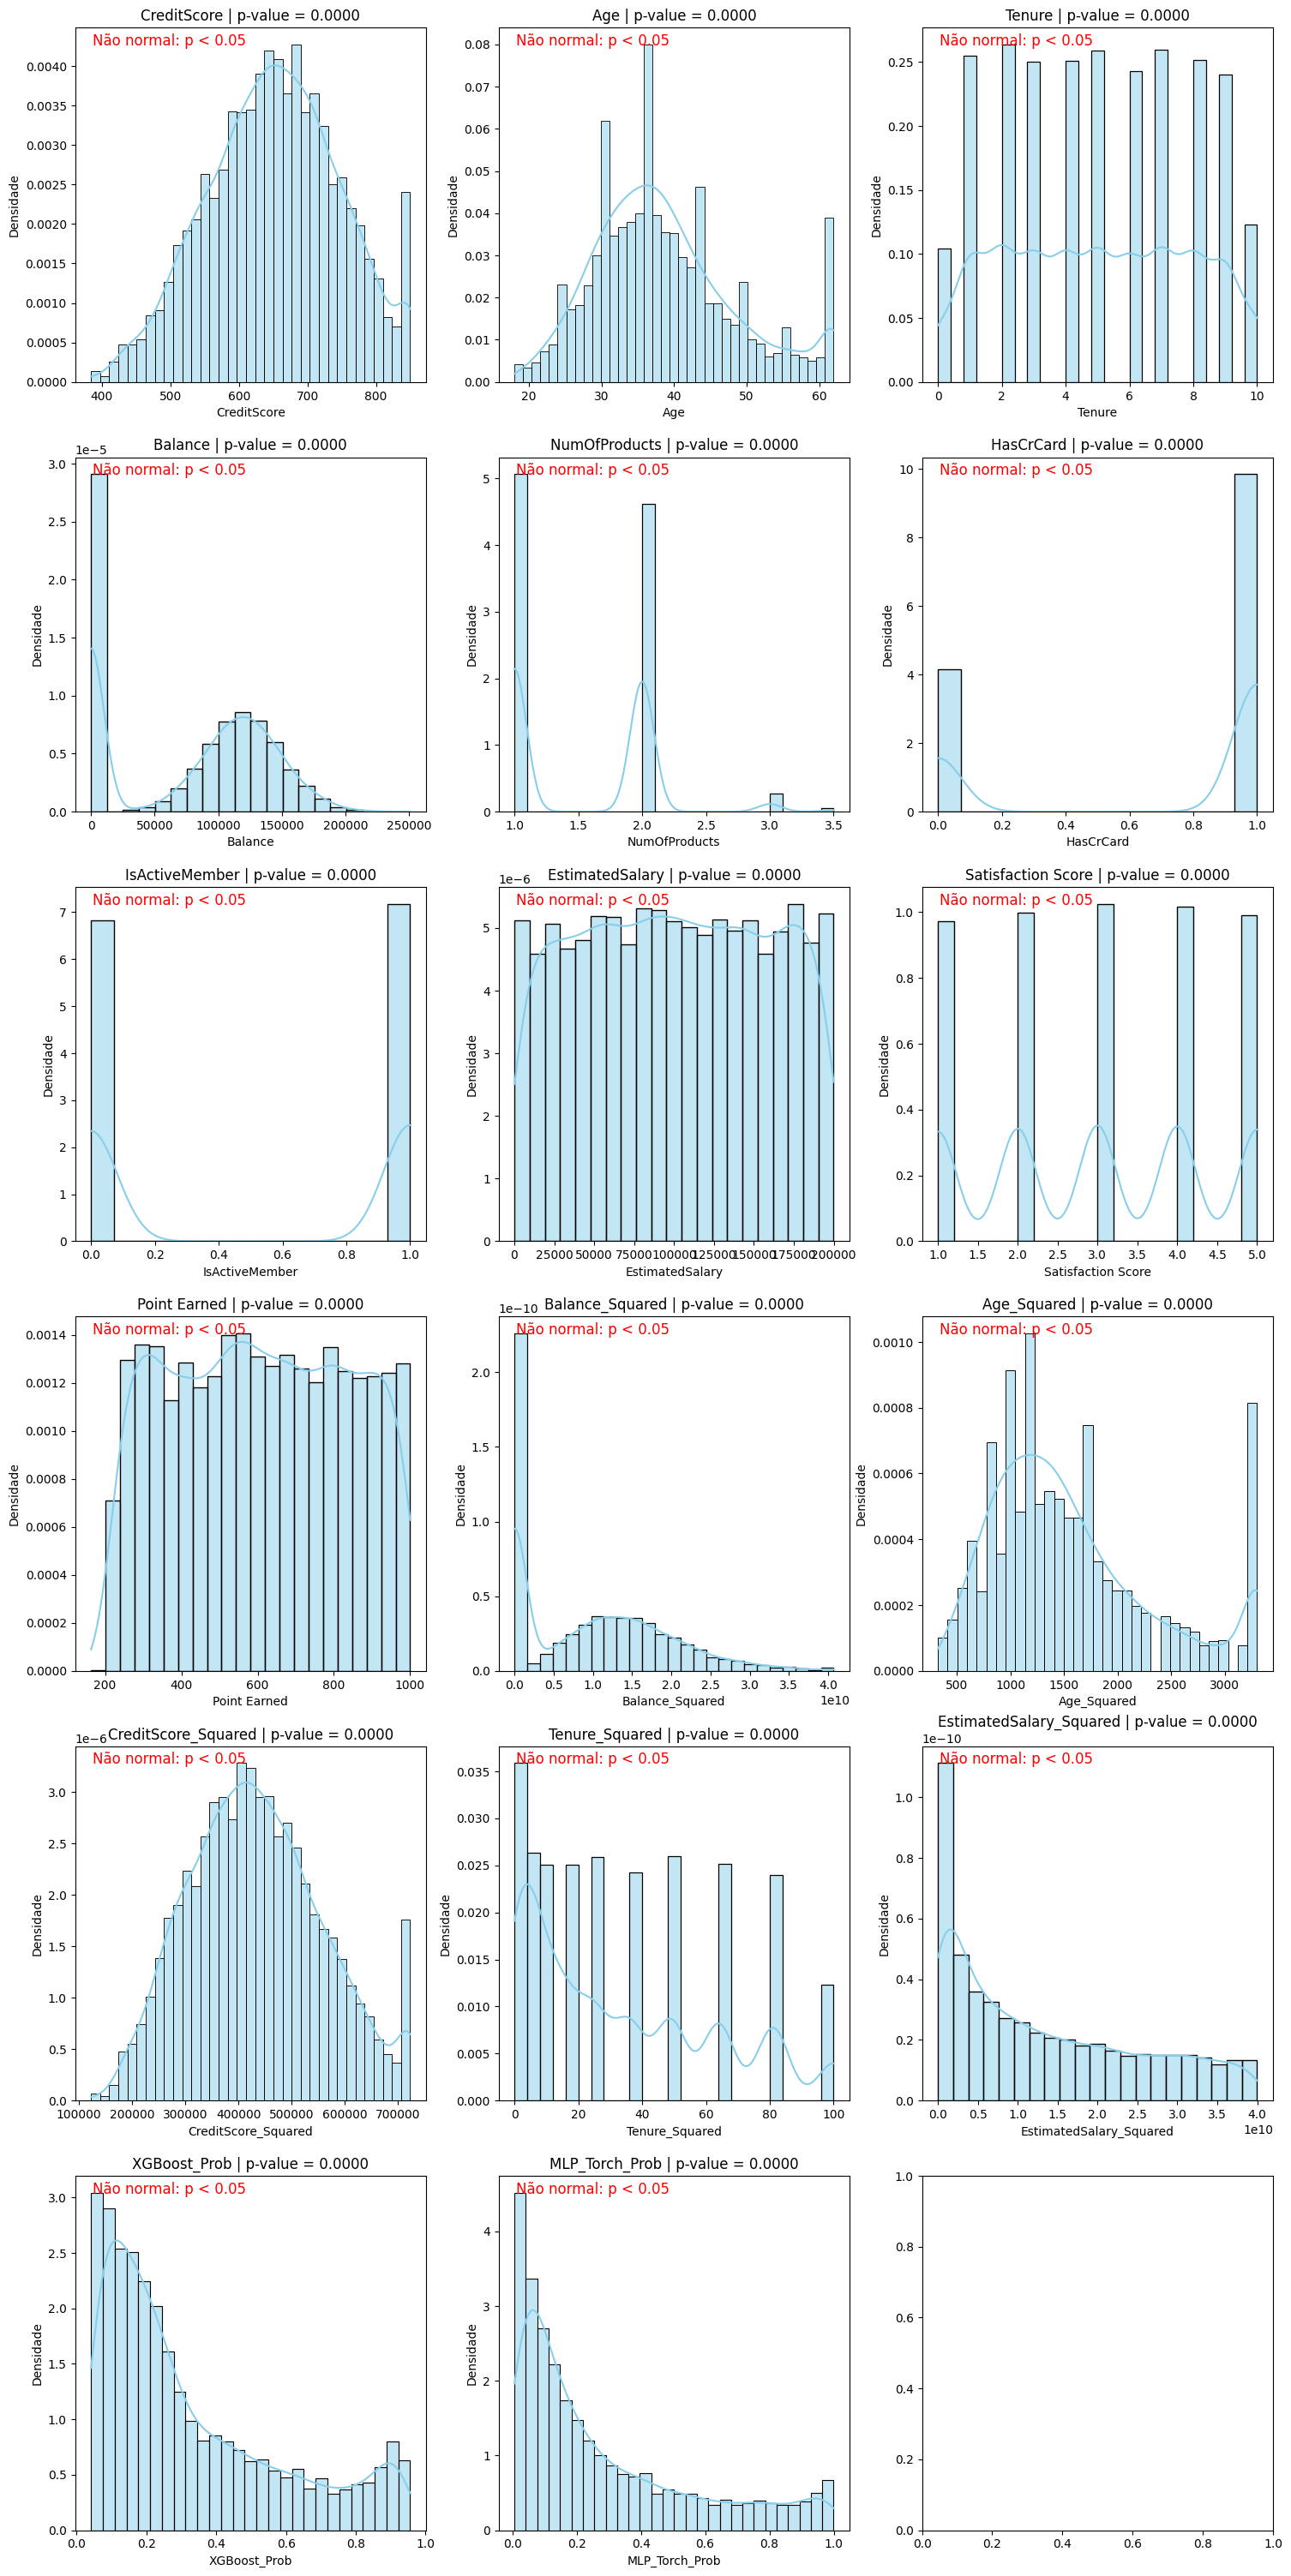

In [23]:
#teste de shapiro

# Definindo o número de colunas para os subplots
num_cols = 3  # O número de colunas 
num_vars = len(X_train_stacking.select_dtypes(include=['float32','float64', 'int64']).columns)  # n variáveis
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)  # Calculando n de linhas dos subplots

# Ajustando o tamanho dos gráficos 
fig_width = 5 * num_cols  # Largura proporcional ao número de colunas
fig_height = 5 * num_rows  # Altura proporcional ao número de linhas

# Criando os subplots 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
axes = axes.flatten()  #  indexar de forma unificada

# Iterando pelas variáveis 
for i, column in enumerate(X_train_stacking.select_dtypes(include=['float32','float64', 'int64']).columns):
   
    # aplicando teste Shapiro
    stat, p = shapiro(X_train_stacking[column])

    # Plotando o histograma e KDE
    sns.histplot(X_train_stacking[column], kde=True, ax=axes[i], color='skyblue', stat='density')
    axes[i].set_title(f"{column} | p-value = {p:.4f}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Densidade')

    # Texto sobre o p-valor e regra
    if p > 0.05:
        axes[i].text(0.05, 0.95, f"Normal: p > 0.05", transform=axes[i].transAxes, fontsize=12, color='green')
    else:
        axes[i].text(0.05, 0.95, f"Não normal: p < 0.05", transform=axes[i].transAxes, fontsize=12, color='red')

# Ajustando layout
plt.tight_layout(pad=0.5)  #espacamento entre os subplots
plt.show()




# Modelo Final - Meta model

GPU não disponível.


Otimização em andamento: 100%|██████████| 10/10 [29:01<00:00, 169.42s/trial]

📊 MELHORES HIPERPARÂMETROS ENCONTRADOS
════════════════════════════════════════════════════════════
learning_rate            0.0003839629299804173
n_hidden_units           162            
n_layers                 3              
dropout_rate             0.5355527884179041
batch_size               256            
epochs                   72             
activation_function      relu           
optimizer                nadam          
weight_decay             0.0026448980183927102
l2_regularization        0.0014492412389916862
════════════════════════════════════════════════════════════


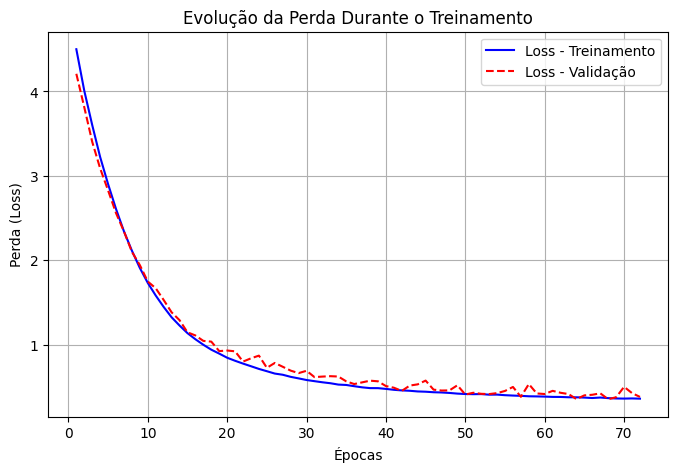

📊 MÉTRICAS FINAIS - TESTE
Métrica                   Valor final
------------------------------------------------------------
Acurácia                  0.8155
Precisão                  0.5230
Recall                    0.6947
F1-Score                  0.5967
AUC-ROC                   0.8400
MCC                       0.4883
Kappa                     0.4802
Acurácia Balanceada       0.7699
Gini                      68.0042


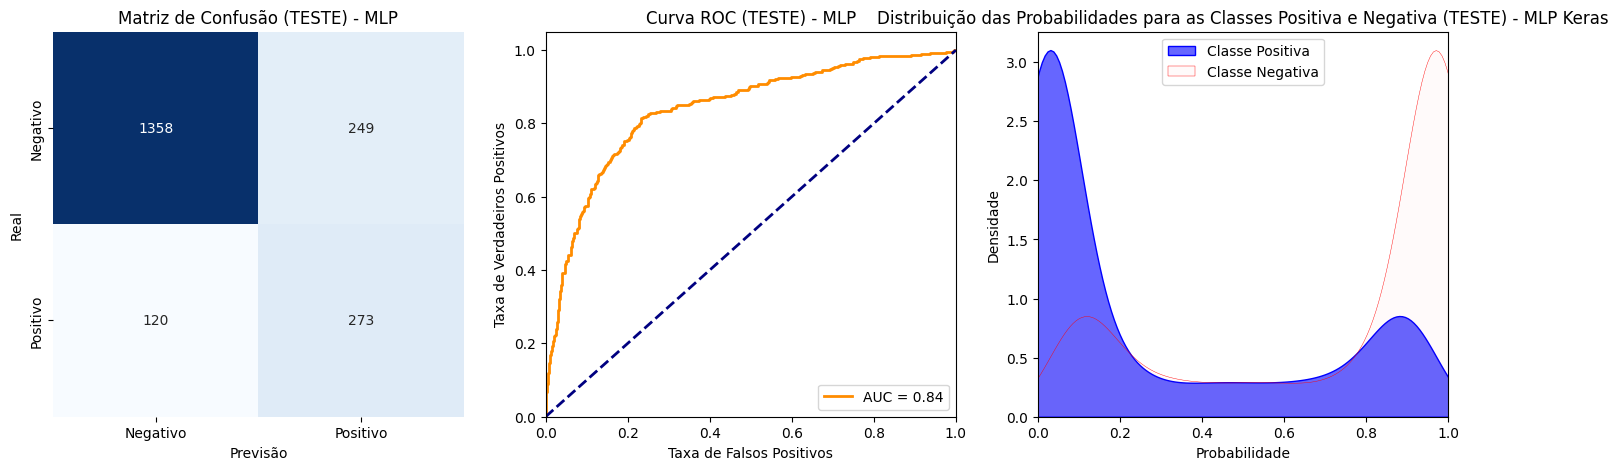

<Figure size 640x480 with 0 Axes>

In [ ]:
# Verificar se há GPU disponível 

#obtive muita dificuldade pelas incompatibilidades de bibliotecas, 
#acabou nao conseguindo puxar GPU, quando estabilizar vale tentar


gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU disponível:", gpus)
else:
    print("GPU não disponível.")

##############variaveis "globais" ###################
n_trials_ = 10
threshold= 0.5
# pesos das métricas para otimização
weights_skf = {
    'Accuracy': 0.00,
    'f1': 0.10,
    'precision': 0.20,
    'recall': 0.50,
    'auc': 0.10,
    'balanced_acc': 0.10,
    'mcc': 0.00
}
progress_bar = tqdm(total=n_trials_, desc="Otimização em andamento", unit="trial") # Definindo a barra de progresso
##################################################


def objective(trial):
    #instanciando scaler e smote
    scaler = MinMaxScaler() 
    smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42) 

    global progress_bar
    global threshold 
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    n_hidden_units = trial.suggest_int('n_hidden_units', 100, 270)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [128, 256])
    epochs = trial.suggest_int('epochs', 30, 100)
    activation_function = trial.suggest_categorical('activation_function', ['relu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'nadam'])
    weight_decay = trial.suggest_float('weight_decay', 0.001, 0.3, log=True)
    l2_regularization = trial.suggest_float('l2_regularization', 0.001, 0.3, log=True)
    momentum = trial.suggest_float('momentum', 0.4, 0.95) if optimizer == 'sgd' else 0.0
    verbose = 0

    # Instanciando e criando modelo MLP
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_stacking.shape[1],)))

    # Definindo o inicializador de pesos com base na função de ativação 
    # (nem todas foram usadas, mas todas foram testadas nos parametros do optuna, a fim de otimizacao final foram removidas.
    #para facilitar estudos futuros foram mantidas na cosntrucao a baixo pois nao impactam)
    for _ in range(n_layers):
        if activation_function == 'relu':
            initializer = 'he_normal'
        elif activation_function == 'tanh':
            initializer = 'glorot_uniform'
        else:
            initializer = 'glorot_uniform'  # Opção padrão 

        model.add(layers.Dense(n_hidden_units, activation=activation_function, #Camada oculta (densa)
                                kernel_initializer=initializer,  # Usando o inicializador 
                                kernel_regularizer=keras.regularizers.l2(l2_regularization)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))  # Camada de saída


    # Compilando o modelo e crinado otimizador
    #(mesma coisa do inicializador, nem todos sao usados mas todos foram testados e mantidos para fins de testes futuros)
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == 'nadam':
        opt = keras.optimizers.Nadam(learning_rate=learning_rate)  # taxa de aprendizado
    else:
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall'])




    # Realizando a validação cruzada estratificada
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    global weights_skf
    weighted_scores = []
    auc_roc_list, accuracy_list, precision_list, recall_list, f1_list, mcc_list, kappa_list, balanced_acc_list = [], [], [], [], [], [], [], []

    for train_idx, val_idx in skf.split(X_train_stacking, y_train):
        X_train_fold, X_val_fold = X_train_stacking.iloc[train_idx], X_train_stacking.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Normalizando os dados (SOMENTE EM TREINO PARA EVITAR VAZAMENTO PARA DADOS DE TESTE)
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)  # Aplica nos dados de validação  (validacao nao e teste, cada fold separado guarda aprox 10% dos dados de treino dele mesmo para validar dentro dele mesmo)

        # Aplicando o BorderlineSMOTE para balancear a classe minoritária (TAMBEM SO NO TREINO)
        X_train_fold_scaled, y_train_fold = smote.fit_resample(X_train_fold_scaled, y_train_fold)

        # Treinando 
        model.fit(X_train_fold_scaled, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=verbose)

        # Prevendo as probabilidades da classe 1
        y_pred_prob = model.predict(X_val_fold_scaled, verbose=verbose).flatten()
        # Garantir que não há NaN nas previsões
        y_pred_prob = np.nan_to_num(y_pred_prob)

        y_pred = (y_pred_prob >= threshold).astype(int)

        auc_roc_list.append(roc_auc_score(y_val_fold, y_pred_prob))
        accuracy_list.append(accuracy_score(y_val_fold, y_pred))
        precision_list.append(precision_score(y_val_fold, y_pred))
        recall_list.append(recall_score(y_val_fold, y_pred))
        f1_list.append(f1_score(y_val_fold, y_pred))
        mcc_list.append(matthews_corrcoef(y_val_fold, y_pred))
        kappa_list.append(cohen_kappa_score(y_val_fold, y_pred))
        balanced_acc_list.append(balanced_accuracy_score(y_val_fold, y_pred))

        # Métricas para otimizar
        metrics_mean = {
            "AUC-ROC": np.mean(auc_roc_list),
            "Accuracy": np.mean(accuracy_list),
            "Precision": np.mean(precision_list),
            "Recall": np.mean(recall_list),
            "F1-Score": np.mean(f1_list),
            "MCC": np.mean(mcc_list),
            "Kappa": np.mean(kappa_list),
            "Balanced Accuracy": np.mean(balanced_acc_list),
        }

        weighted_score = (
            weights_skf['f1'] * metrics_mean["F1-Score"] +
            weights_skf['precision'] * metrics_mean["Precision"] +
            weights_skf['recall'] * metrics_mean["Recall"] +
            weights_skf['auc'] * metrics_mean["AUC-ROC"] +
            weights_skf['balanced_acc'] * metrics_mean["Balanced Accuracy"] +
            weights_skf['Accuracy'] * metrics_mean["Accuracy"] +
            weights_skf['mcc'] * metrics_mean["MCC"]
        )
        weighted_scores.append(weighted_score)

    # Imprimir o resumo das métricas(bom printar quando se quer ver como ele esta performando dentro da validacao cruzada a cada fold)
    #print("📊 MÉTRICAS DOS FOLDS")
    #print("="*60)
    #print(f"{'Métrica':<25} {'Valor final'}")
    #print("-"*60)
    #for metric, value in metrics_mean.items():
    #   print(f"{metric:<25} {value:.4f}")
    #print("="*60)

    progress_bar.update(1)
    return np.mean(weighted_scores)




# Otimização com Optuna (aplicando o construido na funcao objetive com validacao cruzada)
sampler_ = optuna.samplers.TPESampler(n_startup_trials=10, 
                                      n_ei_candidates=50, 
                                      group=True,seed=42,
                                      multivariate=True)

study = optuna.create_study(direction='maximize', sampler=sampler_, pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=20))
study.optimize(objective, n_trials=n_trials_)  
best_params = study.best_params


# Melhores hiperparâmetros
print("📊 MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("═" * 60)
for param, value in best_params.items():
    print(f"{param:<25}{value:<15}")
print("═" * 60)





############## TREINAMENTO FINAL ##############################################

# Criando modelo final com os melhores parâmetros obtidos pelo Optuna 
final_model = keras.Sequential()

# Adicionando a camada de entrada
final_model.add(layers.InputLayer(input_shape=(X_train_stacking.shape[1],)))

# Inicializador de pesos para a camada final (sigmoid)
weight_initializer_final = 'glorot_uniform'  # com Glorot Uniform chumbado para sigmoid

# Inicializador de pesos para as camadas ocultas
if best_params['activation_function'] == 'relu':
    weight_initializer_hidden = 'he_normal'  
elif best_params['activation_function'] == 'tanh':
    weight_initializer_hidden = 'glorot_uniform'  

# Adicionando as camadas ocultas com os melhores parâmetros
for _ in range(best_params['n_layers']):
    final_model.add(layers.Dense(best_params['n_hidden_units'], 
                                 activation=best_params['activation_function'],
                                 kernel_initializer=weight_initializer_hidden,
                                 kernel_regularizer=keras.regularizers.l2(best_params['l2_regularization'] + best_params['weight_decay'])))  # Aplicando weight_decay aqui
    final_model.add(layers.Dropout(best_params['dropout_rate']))  # Dropout após cada camada densa

# Camada de saída sigmoid binaria
final_model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=weight_initializer_final))  

# Escolhendo o otimizador com base nos melhores parâmetros
if best_params['optimizer'] == 'adam':
    opt = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    opt = keras.optimizers.SGD(learning_rate=best_params['learning_rate'], momentum=best_params['momentum'])
else:
    opt = keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])

# Compilando o modelo
final_model.compile(optimizer=opt, 
                    loss='binary_crossentropy', 
                    metrics=['AUC', 'accuracy', 'Precision', 'Recall'])


# Normalizando os dados 
# (lembrando que o aplicado anteriormente foi dentro dos k-folds, por isso inicializar aqui de novo)

scaler = MinMaxScaler() # inicia normalizador
X_train_scaled = scaler.fit_transform(X_train_stacking)

# Aplicando o BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

# Criando o callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorando a perda de validação
    patience=20,  # Se não houver melhoria por esse n de épocas, o treinamento será interrompido
    restore_best_weights=True,  # Restaurando os melhores pesos do modelo
    verbose=0  # inibindo mensagens de log  
)

# Treinando o modelo
history = final_model.fit(
    X_train_scaled, 
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,  
    validation_split=0.2,  #20% dados para validação
    callbacks=[early_stopping]  # Passando o callback de EarlyStopping
)



#plotando perda por epoca 
loss = history.history['loss'] # Extraindo os valores da perda do histórico de treinamento
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Loss - Treinamento', color='blue')
plt.plot(epochs_range, val_loss, label='Loss - Validação', color='red', linestyle='dashed')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.title('Evolução da Perda Durante o Treinamento')
plt.legend()
plt.grid(True)

plt.show()


# Normalizando os dados de teste (AQUI E SO APLICACAO - TRANSFORM - FIT_TARNSFORM E APLICADO SOMENTE NO TREINO)
X_test_scaled = scaler.transform(X_test_stacking)

# Fazendo predições
y_pred_final_prob = final_model.predict(X_test_scaled,verbose=0).flatten()  # Obtendo as probabilidades

# Definindo o limiar de decisao (thresfold)
y_pred_final = (y_pred_final_prob >= threshold).astype(int)  # O limiar padrão é 0.5, mas pode ser ajustado



# Cálculo das métricas
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
auc_roc = roc_auc_score(y_test, y_pred_final_prob)
mcc = matthews_corrcoef(y_test, y_pred_final)
kappa = cohen_kappa_score(y_test, y_pred_final)
balanced_acc = balanced_accuracy_score(y_test, y_pred_final)
gini = (2 * auc_roc - 1) * 100

# Exibir as métricas finais
print("📊 MÉTRICAS FINAIS - TESTE")
print("=" * 60)
print(f"{'Métrica':<25} {'Valor final'}")
print("-" * 60)
print(f"{'Acurácia':<25} {accuracy:.4f}")
print(f"{'Precisão':<25} {precision:.4f}")
print(f"{'Recall':<25} {recall:.4f}")
print(f"{'F1-Score':<25} {f1:.4f}")
print(f"{'AUC-ROC':<25} {auc_roc:.4f}")
print(f"{'MCC':<25} {mcc:.4f}")
print(f"{'Kappa':<25} {kappa:.4f}")
print(f"{'Acurácia Balanceada':<25} {balanced_acc:.4f}")
print(f"{'Gini':<25} {gini:.4f}")
print("=" * 60)

# Criando conjunto de Plots 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot da Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'],
            cbar=False, ax=axes[0])
axes[0].set_title('Matriz de Confusão (TESTE) - MLP')
axes[0].set_xlabel('Previsão')
axes[0].set_ylabel('Real')

# Plot da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_final_prob)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taxa de Falsos Positivos')
axes[1].set_ylabel('Taxa de Verdadeiros Positivos')
axes[1].set_title('Curva ROC (TESTE) - MLP')
axes[1].legend(loc="lower right")


# Plot de Distribuição de probabilidades

# classe positiva
probs_pos = y_pred_final_prob  
# classe negativa
probs_neg = 1 - y_pred_final_prob

# Plot classe positiva 
sns.kdeplot(probs_pos, color='blue', ax=axes[2], label='Classe Positiva', fill=True, alpha=0.6)
# Plot classe negativa 
sns.kdeplot(probs_neg, color='red', ax=axes[2], label='Classe Negativa', fill=True, alpha=0.02, linewidth=0.30)
axes[2].set_title("Distribuição das Probabilidades para as Classes Positiva e Negativa (TESTE) - MLP Keras")
axes[2].set_xlabel("Probabilidade")
axes[2].set_ylabel("Densidade")
axes[2].legend()
# setando eixo de probabilidades entre 0 e 1
axes[2].set_xlim(0, 1)

plt.show()


# Ajustando o layout
plt.tight_layout()
plt.show()


#final_model.summary() #infos do modelo quando necessario ver "dentro" das configs do modelo



#salvando modelo e scaler para aplicar com dados novos (simulacao de prod) futuramente

final_model.save("modelo_mlp.h5")
joblib.dump(scaler, "scaler.pkl")



# Explicabilidade 

* Importante para explicar como o modelo tomou as decisoes de forma global e local (de acordo com a observacao selecionada)

* Vale lembrar que foi feita a selecao de variaveis com base na importancia delas com RamdomForest la atras (muito semelhante ao que veremos a baixo, principalmente o grafico de barras global do shap) mas que nao tinha a intencao de explicabilidade, embora sejam muito parecidas as aplicacoes (e podem ter a mesma finalidade de eliminar variaveis), somente agora a intencao e de explicabilidade. La atras a intencao era selecao de variaveis importantes. 



# SHAP Global

* SHAP Global é uma técnica de explicabilidade que ajuda a entender a importância de cada variável nas predições do modelo de maneira global, ou seja, avaliando o impacto médio de cada feature ao longo de todas as instâncias do conjunto de dados.




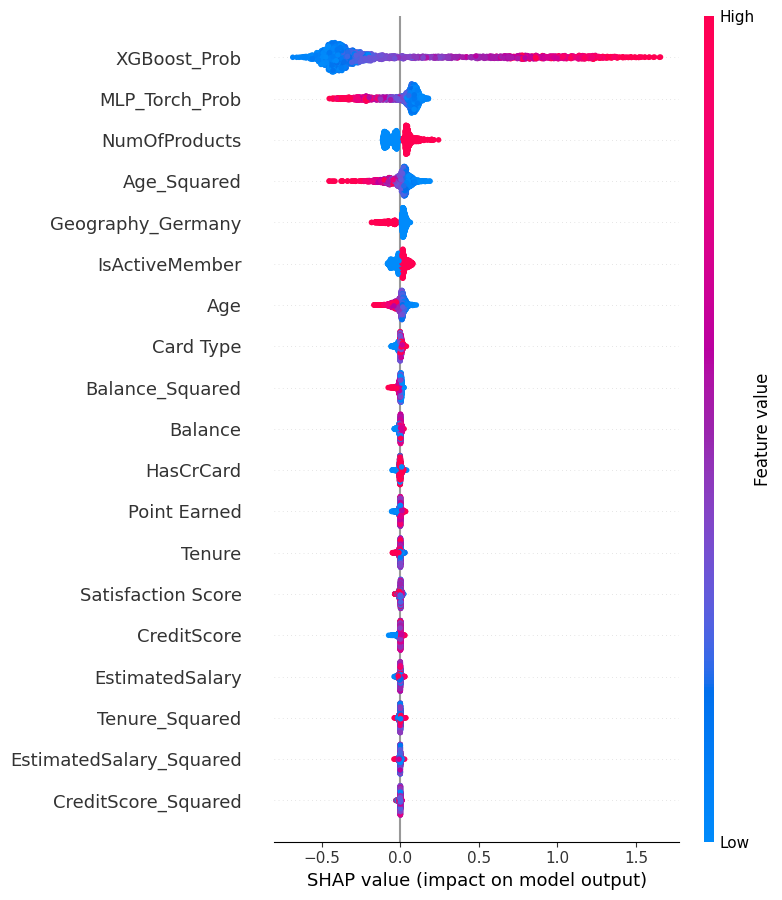

In [25]:
#definindo tamanho de df_de toda a analise de shap (local e global)
tamanho_df_shap = 5000

# explicador SHAP usando DeepExplainer 
background_samples = X_train_scaled[:tamanho_df_shap]
explainer = shap.DeepExplainer(final_model, background_samples)

# Calcular SHAP 
shap_values = explainer.shap_values(X_test_scaled)

# Gerar gráfico 
shap_values_fixed = np.squeeze(shap_values, axis=-1)

# Transformar X_test_scaled de volta para DataFrame para garantir os nomes das colunas na hora do plot 
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_stacking.columns)

# plotando
shap.summary_plot(shap_values_fixed, X_test_scaled_df, feature_names=X_test_scaled_df.columns)


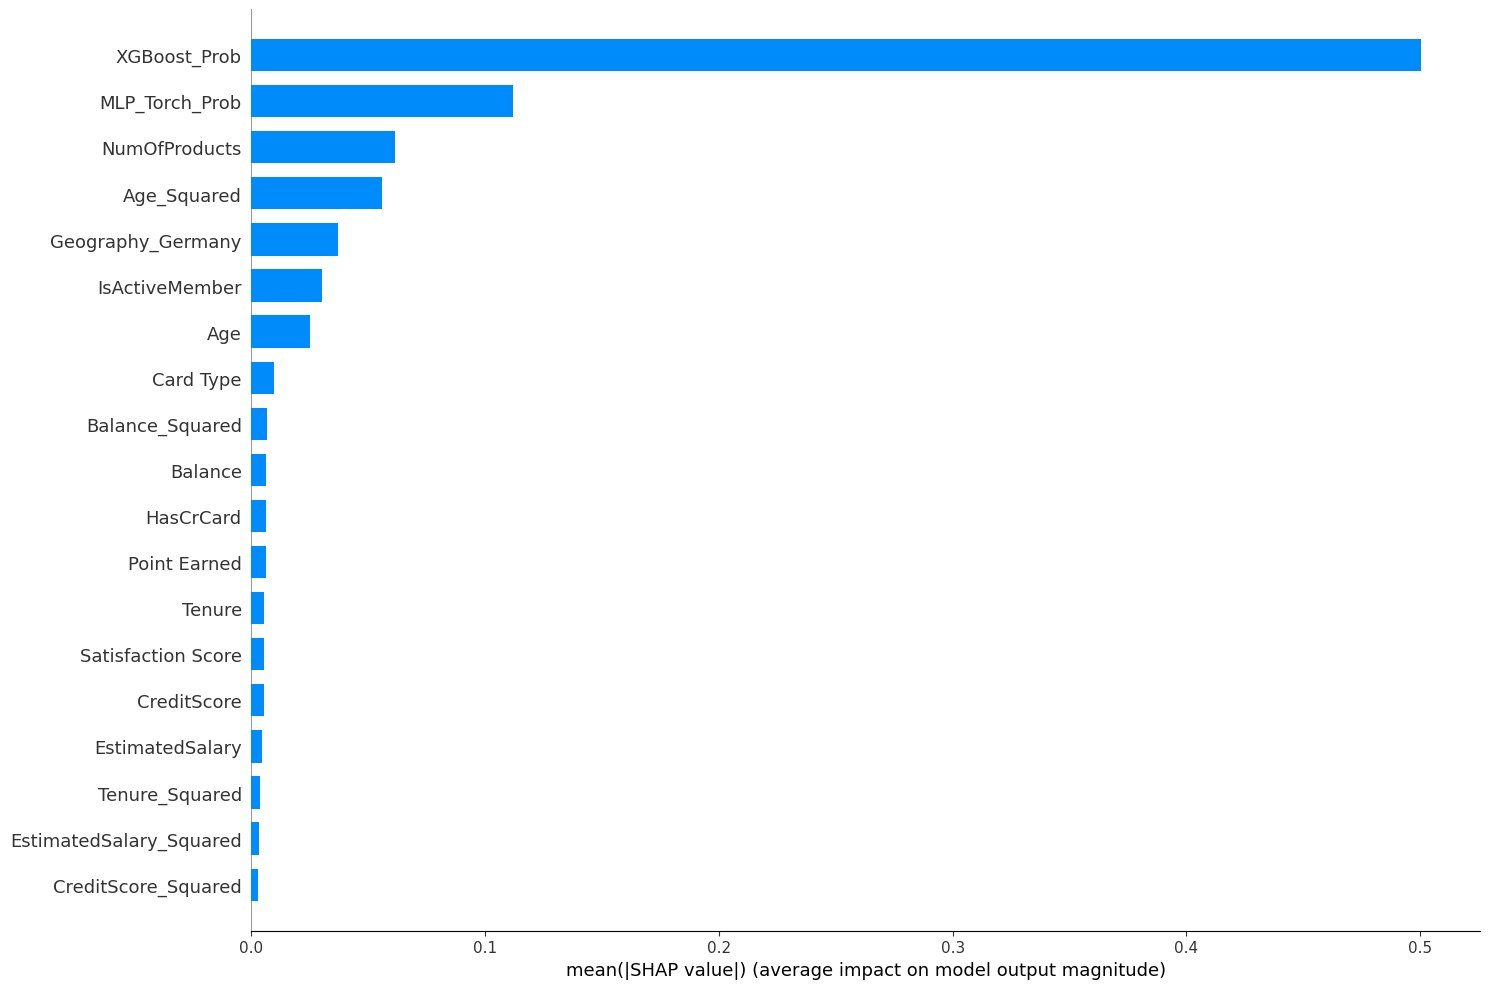

In [26]:
# gráfico SHAP em barras
shap.summary_plot(shap_values_fixed, X_test_scaled_df, feature_names=X_test_scaled_df.columns,plot_type="bar",plot_size=(15,10))

# Selecionando exemplos de classes (churn e nao churn real) para SHAP E LIME LOCAL

In [27]:
# Def para exibir exemplos de linhas com classe 0 ou 1
def exibir_exemplos(y_test, num_exemplos=10):
    # indices linhas com classe 0
    indices_classe_0 = np.where(y_test == 0)[0][:num_exemplos]
    # indices linhas com classe 1
    indices_classe_1 = np.where(y_test == 1)[0][:num_exemplos]

    # Exibir exemplos de classe 0
    print("Exemplos de linhas com classe 0:")
    for i, idx in enumerate(indices_classe_0):
        print(f"Exemplo {i + 1}: Linha {idx}")

    # Exibir exemplos de classe 1
    print("\nExemplos de linhas com classe 1:")
    for i, idx in enumerate(indices_classe_1):
        print(f"Exemplo {i + 1}: Linha {idx}")



# chamndo df para printar
exibir_exemplos(y_test, num_exemplos=10)

Exemplos de linhas com classe 0:
Exemplo 1: Linha 0
Exemplo 2: Linha 1
Exemplo 3: Linha 2
Exemplo 4: Linha 3
Exemplo 5: Linha 4
Exemplo 6: Linha 5
Exemplo 7: Linha 6
Exemplo 8: Linha 8
Exemplo 9: Linha 9
Exemplo 10: Linha 13

Exemplos de linhas com classe 1:
Exemplo 1: Linha 7
Exemplo 2: Linha 10
Exemplo 3: Linha 11
Exemplo 4: Linha 12
Exemplo 5: Linha 22
Exemplo 6: Linha 25
Exemplo 7: Linha 35
Exemplo 8: Linha 36
Exemplo 9: Linha 40
Exemplo 10: Linha 41


# SHAP LOCAL - Classe 0 (NAO CHURN)

<Figure size 1400x600 with 0 Axes>

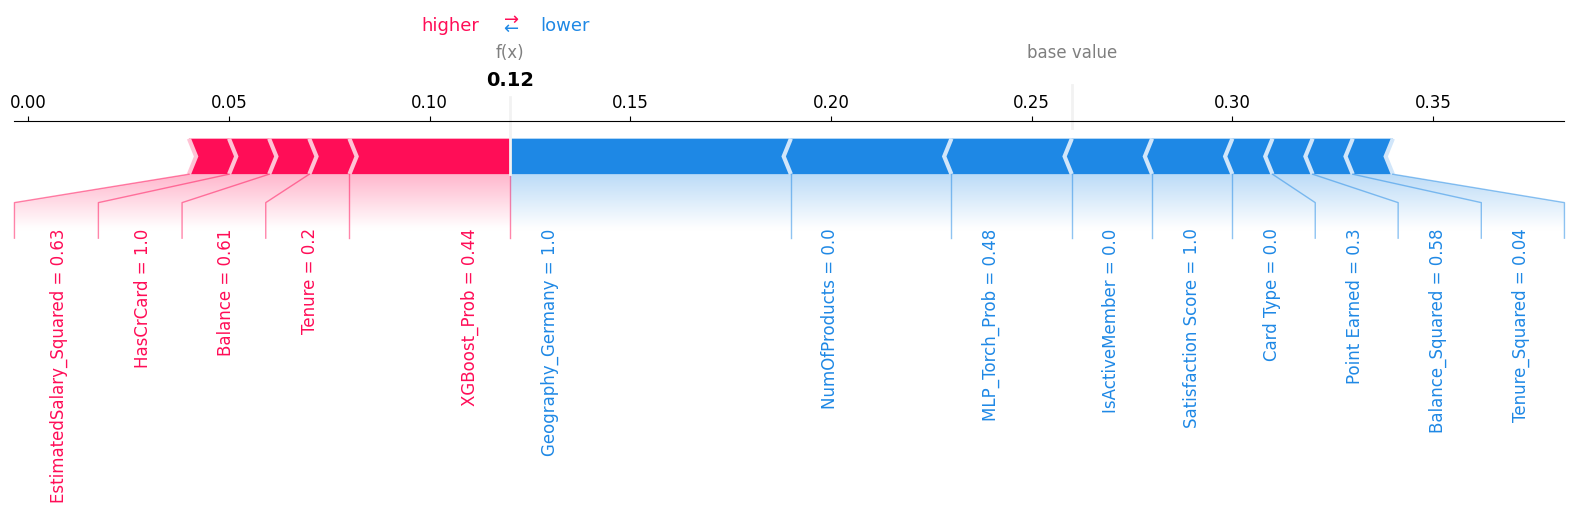

Análise SHAP Local - Linha 13 | Classe Real: 0 NAO CHURN 


<Figure size 640x480 with 0 Axes>

In [32]:

linha_nao_churn = 13 # numero da Linha (observacao) a se analisar

# Explicador SHAP 
background_samples = X_train_scaled[:tamanho_df_shap]
explainer = shap.DeepExplainer(final_model, background_samples)

# Calculo SHAP  
shap_values = explainer.shap_values(X_test_scaled)

# Transformar X_test_scaled de volta para DataFrame para garantir os nomes das colunas na hora do plot
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_stacking.columns)

# Selecionar a linha especificada 
shap_values_local = np.squeeze(shap_values, axis=-1)[linha_nao_churn]  # Valores SHAP 
X_test_local = X_test_scaled_df.iloc[linha_nao_churn].values  # Valores das características 
y_test_local = y_test.iloc[linha_nao_churn]  # Label real (0 ou 1) para a linha 

# valores para duas casas decimais
shap_values_local_rounded = np.round(shap_values_local, 2) 
X_test_local_rounded = np.round(X_test_local, 2)           
expected_value_rounded = np.round(explainer.expected_value, 2)  

# Criar uma figura com fundo branco (para conseguir ver em temas dark)
plt.figure(facecolor='white', figsize=(14, 6))  

plt.rcParams['font.size'] = 12  # tamanho da fonte dos valores

# gráfico SHAP local
shap.initjs()  # Inicializar JavaScript (acabou nem sendo util, quando apica matplotlib ele fica estatico)
shap.force_plot(
    expected_value_rounded,     # Valor esperado do modelo 
    shap_values_local_rounded,  # Valores SHAP para a linha 
    X_test_local_rounded,       # Valores das características para a linha 
    feature_names=X_test_scaled_df.columns,  # Nomes colunas
    matplotlib=True,            # Usar matplotlib no plot
    text_rotation=90            # inclinacao to nome das variáveis 
)

titulo = f"Análise SHAP Local - Linha {linha_nao_churn} | Classe Real: {y_test_local} NAO CHURN "
print(titulo)


# pltando
plt.gcf().set_facecolor('white')  # Define o fundo do gráfico como branco
plt.show()





# SHAP LOCAL - Classe 1 (CHURN)

<Figure size 1400x600 with 0 Axes>

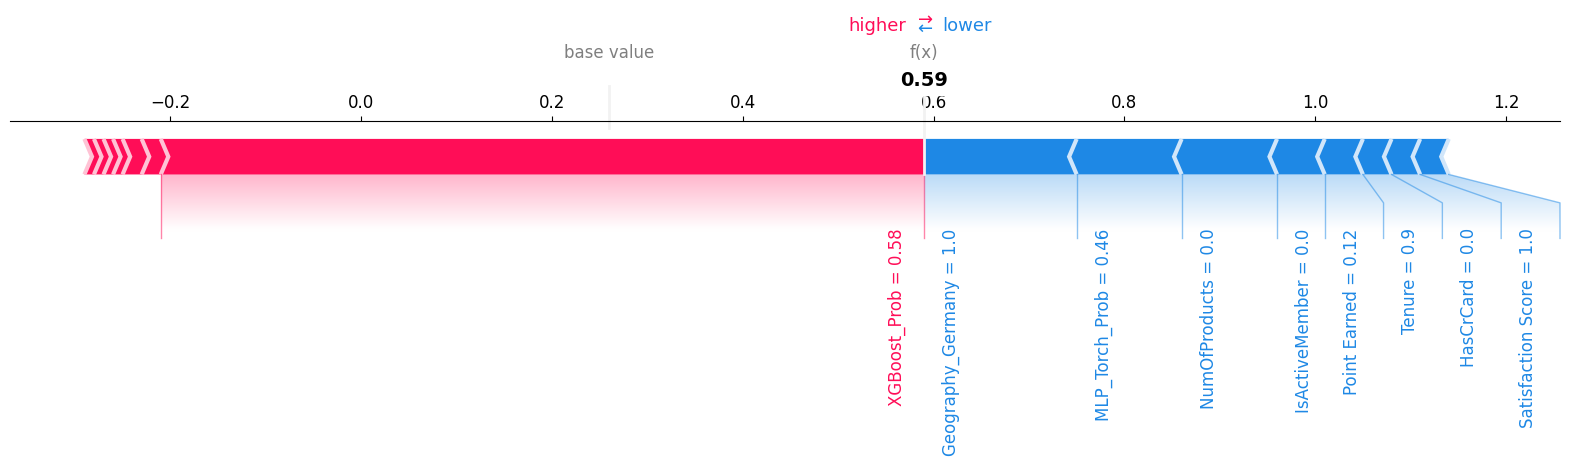

Análise SHAP Local - Linha 36 | Classe Real: 1 CHURN 


<Figure size 640x480 with 0 Axes>

In [33]:

linha_churn = 36 # numero da Linha (observacao) a se analisar

# Explicador SHAP 
background_samples = X_train_scaled[:tamanho_df_shap]
explainer = shap.DeepExplainer(final_model, background_samples)

# Calculo SHAP  
shap_values = explainer.shap_values(X_test_scaled)

# Transformar X_test_scaled de volta para DataFrame para garantir os nomes das colunas na hora do plot
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_stacking.columns)

# Selecionar a linha especificada 
shap_values_local = np.squeeze(shap_values, axis=-1)[linha_churn]  # Valores SHAP 
X_test_local = X_test_scaled_df.iloc[linha_churn].values  # Valores das características 
y_test_local = y_test.iloc[linha_churn]  # Label real (0 ou 1) para a linha 

# valores para duas casas decimais
shap_values_local_rounded = np.round(shap_values_local, 2) 
X_test_local_rounded = np.round(X_test_local, 2)           
expected_value_rounded = np.round(explainer.expected_value, 2)  

# Criar uma figura com fundo branco (para conseguir ver em temas dark)
plt.figure(facecolor='white', figsize=(14, 6))  

plt.rcParams['font.size'] = 12  # tamanho da fonte dos valores

# gráfico SHAP local
shap.initjs()  # Inicializar JavaScript (acabou nem sendo util, quando apica matplotlib ele fica estatico)
shap.force_plot(
    expected_value_rounded,     # Valor esperado do modelo 
    shap_values_local_rounded,  # Valores SHAP para a linha 
    X_test_local_rounded,       # Valores das características para a linha 
    feature_names=X_test_scaled_df.columns,  # Nomes colunas
    matplotlib=True,            # Usar matplotlib no plot
    text_rotation=90            # inclinacao to nome das variáveis 
)

titulo = f"Análise SHAP Local - Linha {linha_churn} | Classe Real: {y_test_local} CHURN "
print(titulo)


# pltando
plt.gcf().set_facecolor('white')  # Define o fundo do gráfico como branco
plt.show()





# LIME (Local) 

* LIME (Local Interpretable Model-agnostic Explanations) é uma técnica de explicabilidade que busca interpretar predições de modelos de forma local, ou seja, explicar como o modelo chegou a uma decisão específica para uma instância de dado individual. 

*  O LIME foca na explicação de uma única predição. 

* Aplicado para comparar com o SHAP Local 

# LIME classe 0 (NAO CHURN)

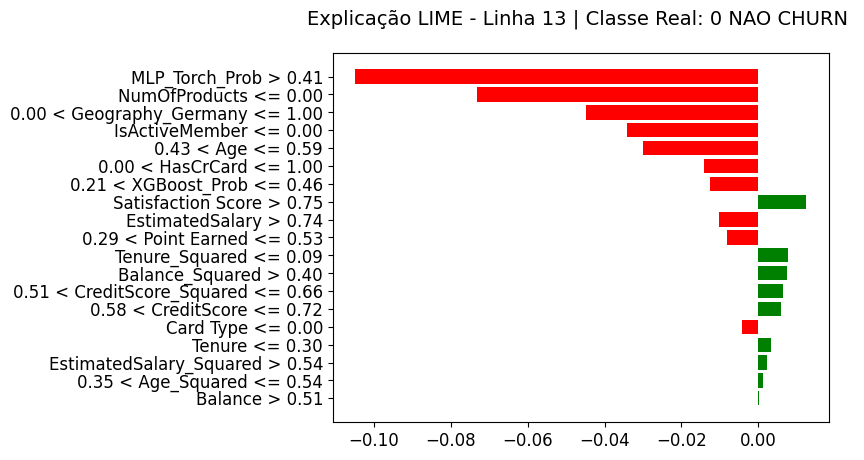

In [34]:
# Criando o explicador LIME 
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled[:tamanho_df_shap],   
    mode="classification",          # Tipo de problema (classificação)
    class_names=["Negativo", "Positivo"],  # Nomes das clas
    feature_names=X_test_stacking.columns,  # Nomes das variáveis
    discretize_continuous=True      # Discretizar variáveis contínuas
)

# Selecionando uma linha para explicar
instance = X_test_scaled[linha_nao_churn].reshape(1, -1)  #selecioando linha/observcacao/instancia (mesma do shap para comparar)

# Função para obter probabilidades do MLP
def predict_proba_fn(x):

    # O Keras retorna apenas a probabilidade da classe positiva
    proba_positiva = final_model.predict(x, verbose=0)
    #calculando a classe negativa
    proba_negativa = 1 - proba_positiva
    return np.hstack((proba_negativa, proba_positiva))  # Concatenar as probabilidades

# Gerando explicação local com probabilidades de classe
explanation = explainer.explain_instance(
    instance.flatten(),  # Passando a instância em formato adequado
    predict_proba_fn,    # Função que retorna probabilidade
    num_features=20,     # Número de características a serem exibidas
    num_samples=5000     # Aumenta a estabilidade da explicação
)

# Plotando a explicação local
fig = explanation.as_pyplot_figure()
plt.title(f"Explicação LIME - Linha {linha_nao_churn} | Classe Real: {y_test.iloc[linha_nao_churn]} NAO CHURN ", fontsize=14, pad=20)
plt.show()

# LIME classe 1 (CHURN)

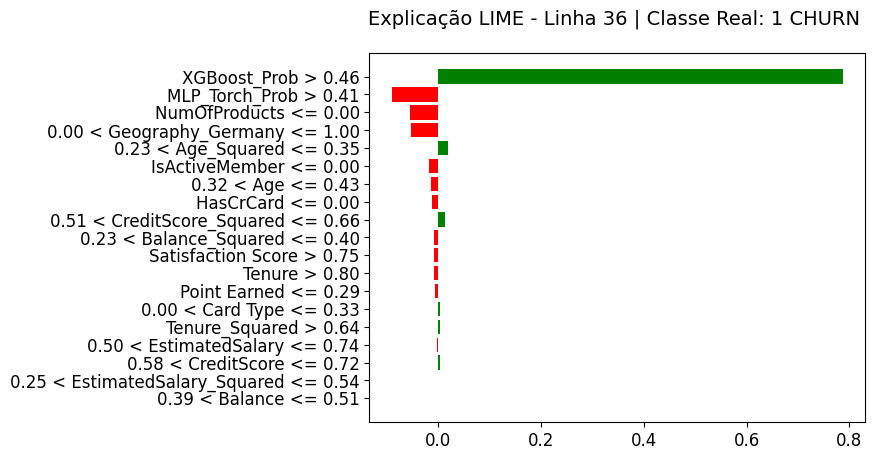

In [35]:
# Criando o explicador LIME 
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled[:tamanho_df_shap],   
    mode="classification",          # Tipo de problema (classificação)
    class_names=["Negativo", "Positivo"],  # Nomes das clas
    feature_names=X_test_stacking.columns,  # Nomes das variáveis
    discretize_continuous=True      # Discretizar variáveis contínuas
)

# Selecionando uma linha para explicar
instance = X_test_scaled[linha_churn].reshape(1, -1)  #selecioando linha/observcacao/instancia (mesma do shap para comparar)


# Função para obter probabilidades do MLP
def predict_proba_fn(x):

    # O Keras retorna apenas a probabilidade da classe positiva
    proba_positiva = final_model.predict(x, verbose=0)
    #calculando a classe negativa
    proba_negativa = 1 - proba_positiva
    return np.hstack((proba_negativa, proba_positiva))  # Concatenar as probabilidades

# Gerando explicação local com probabilidades de classe
explanation = explainer.explain_instance(
    instance.flatten(),  # Passando a instância em formato adequado
    predict_proba_fn,    # Função que retorna probabilidade
    num_features=20,     # Número de características a serem exibidas
    num_samples=5000     # Aumenta a estabilidade da explicação
)

# Plotando a explicação local
fig = explanation.as_pyplot_figure()
plt.title(f"Explicação LIME - Linha {linha_churn} | Classe Real: {y_test.iloc[linha_churn]} CHURN ", fontsize=14, pad=20)
plt.show()

# FIM